# Notebook Regresion Lineal 2 Reto: Interlub
Author: A. Ramirez-Morales (andres.ramirez@tec.mx)


## Instrucciones:
- Active su entorno de `conda`
- Complete las funciones donde vea líneas de código inconclusas
- Use comentarios para documentar de manera integral sus funciones
- Pruebe sus funciones con distintos parámetros
- Aumente las explicaciones en el Markdown y en el código

In [36]:
# cargar librerías básicas
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, shapiro
import pandas as pd

# 1. Base de datos numerica
*Ejercicio:* Cargue los datos previamente preparados 100% numericos

In [37]:
df = pd.read_csv("data/datos_grasas_Tec_limpio.csv")

## 2. Generacion de datos mas avanzada

### 2.1. Simulacion mediante KNN 

*Ejercicio:* Agregar explicacion detallada del algoritmo y de la funcion

In [38]:
def simular_datos_knn(df_original, n_nuevos=100, k=5):
    """
    Genera datos sintéticos interpolando entre vecinos cercanos.
    SOLO usa columnas numéricas y maneja -99 / NaNs.
    """
    # Solo columnas numéricas
    df_num = df_original.select_dtypes(include=np.number).copy()

    # Reemplazar sentinelas y NaNs por la media de cada columna
    df_num = df_num.replace(-99, np.nan)
    df_num = df_num.fillna(df_num.mean())

    X = df_num.to_numpy(dtype=float)

    # Normalización básica
    n, d = X.shape
    mean = X.mean(axis=0)
    std = X.std(axis=0) + 1e-8
    Xn = (X - mean) / std

    nuevos = []
    for _ in range(n_nuevos):
        base = Xn[np.random.randint(0, n)]
        dist = np.sqrt(np.sum((Xn - base) ** 2, axis=1))
        vecinos_idx = np.argsort(dist)[1:k+1]
        vecino = Xn[np.random.choice(vecinos_idx)]
        nuevo = base + np.random.rand() * (vecino - base)
        nuevos.append(nuevo)

    nuevos = np.array(nuevos)

    # Deshacer normalización
    X_new = nuevos * std + mean

    return pd.DataFrame(X_new, columns=df_num.columns)


### 2.2. Simulacion mediante Gaussian Copulas

Ejercicios:
- Describa para que nos sirven las copulas gaussianas
- Revise la documentacion https://sdv.dev/Copulas/
- Encuentre que funciones podrian mejorar la funcionalidad en la funcion que escribio el profesor abajo


In [39]:
from copulas.multivariate import GaussianMultivariate
import pandas as pd

def simular_datos_copula(df_original, n_nuevos=100):
    
    """Genera datos sintéticos con una cópula gaussiana.
    SOLO usa columnas numéricas y maneja -99 / NaNs."""
    
    df_num = df_original.select_dtypes(include=np.number).copy()

      
    df_num = df_num.replace(-99, np.nan)
    df_num = df_num.fillna(df_num.mean())

    model = GaussianMultivariate()
    model.fit(df_num)
    df_nuevo = model.sample(n_nuevos)

    return df_nuevo

### 2.3. Simulacion con Variational AutoEncoder 

Los VAE aprenden un espacio latente continuo del cual se puede muestrear.

Muy útiles si tus datos tienen una estructura suave (por ejemplo, mediciones físicas).

In [40]:
import torch
from torch import nn

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=5):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def encode(self, x):
        mu_logvar = self.encoder(x)
        mu, logvar = mu_logvar.chunk(2, dim=-1)
        logvar = torch.clamp(logvar, min=-10, max=10)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


def simular_datos_vae(df_original, n_nuevos=100, latent_dim=5, epochs=500, lr=1e-4):
    """
    documentar
    """
    df_num = df_original.select_dtypes(include=np.number).replace(-99, np.nan)
    df_num = df_num.fillna(df_num.mean())
    X = df_num.values

    # comentar
    mean = X.mean(axis=0)
    std = X.std(axis=0) + 1e-8
    X_norm = (X - mean) / std

    # comentar
    X_tensor = torch.tensor(X_norm, dtype=torch.float32)

    vae = VAE(input_dim=X.shape[1], latent_dim=latent_dim)
    # comentar
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

    def loss_fn(recon_x, x, mu, logvar):
        recon_loss = nn.functional.mse_loss(recon_x, x) # comentar
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) # comentar
        return recon_loss + kl_loss

    for epoch in range(epochs):
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(X_tensor)
        loss = loss_fn(recon_x, X_tensor, mu, logvar)
        loss.backward()
        optimizer.step()

        if torch.isnan(loss):
            break

    # generacion de datos
    with torch.no_grad():
        z = torch.randn(n_nuevos, latent_dim)
        X_new_norm = vae.decoder(z).numpy()

    # quitar la norm,.
    X_new = X_new_norm * std + mean
    return pd.DataFrame(X_new, columns=df_num.columns)


# 3. Regresión lineal

### 3.1 Definir, probar el modelo y graficar resultados

## Utilizando VAE (Variable Predictora: Viscosidad del Aceite Base a 40°C. cSt)

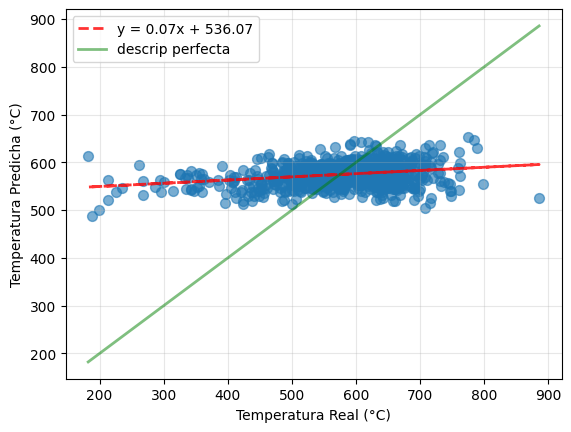

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


def variables_regresion(df, variable_objetivo, variables_predictoras):
    """
    completar documentacion
    """
    # quedarnos solo con las filas completas
    df_filtrado = df.copy()
    for var in variables_predictoras + [variable_objetivo]:
        df_filtrado = df_filtrado[df_filtrado[var] != -99]
    
    X = df_filtrado[variables_predictoras]
    y = df_filtrado[variable_objetivo]
    
    return X, y, variables_predictoras
# definir variable objetivo
variable_objetivo="Viscosidad del Aceite Base a 40°C. cSt"

# definir variables predictoras
variables_predictoras = [
    "Punto de Gota, °C",
    "Punto de Soldadura Cuatro Bolas, kgf",
    "Desgaste Cuatro Bolas, mm",
    "Temperatura de Servicio °C, min",
    "Temperatura de Servicio °C, max"
]


# pruebe
expanded_data = simular_datos_vae(df, n_nuevos=1000)
# expanded_data = simular_datos_knn(df, n_nuevos=1000)
# expanded_data = simular_datos_copula(df, n_nuevos=1000)

X, y, features = variables_regresion(expanded_data, variable_objetivo, variables_predictoras)
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)
    
y_pred_train = modelo.predict(X_train_scaled)
y_pred_test = modelo.predict(X_test_scaled)
    
# metricas
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
# agregar R cuadrada


# graficar
y_pred = y_pred_train
y_real = y_train

# linea de regresion para las predicciones
z = np.polyfit(y_real, y_pred, 1)
p = np.poly1d(z)
    
plt.scatter(y_real, y_pred, alpha=0.6, s=50)
plt.plot(y_real, p(y_real), "r--", alpha=0.8, linewidth=2, 
             label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
    
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 
             'g-', alpha=0.5, linewidth=2, label='descrip perfecta')
    
plt.xlabel('Temperatura Real (°C)')
plt.ylabel('Temperatura Predicha (°C)')
plt.legend()
plt.grid(True, alpha=0.3)

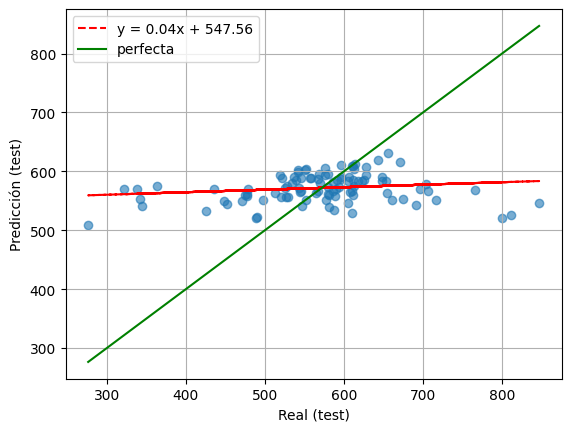

In [42]:
# graficar test
y_pred = y_pred_test
y_real = y_test

z = np.polyfit(y_real, y_pred, 1)
p = np.poly1d(z)

plt.scatter(y_real, y_pred, alpha=0.6)
plt.plot(y_real, p(y_real), "r--", label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()],
         'g-', label='perfecta')
plt.xlabel('Real (test)')
plt.ylabel('Predicción (test)')
plt.legend()
plt.grid(True)
plt.show()


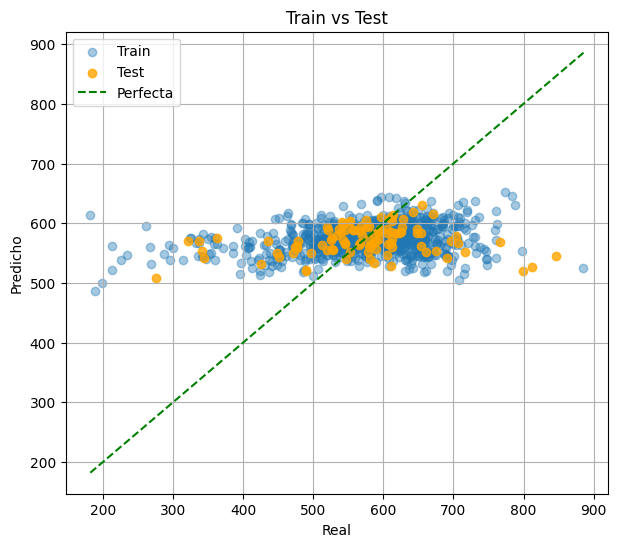

In [43]:
plt.figure(figsize=(7,6))

# Train
plt.scatter(y_train, y_pred_train, alpha=0.4, label="Train")

# Test
plt.scatter(y_test, y_pred_test, alpha=0.8, label="Test", color='orange')

# Línea perfecta
min_val = min(y_train.min(), y_test.min())
max_val = max(y_train.max(), y_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'g--', label='Perfecta')

plt.xlabel("Real")
plt.ylabel("Predicho")
plt.legend()
plt.grid(True)
plt.title("Train vs Test")
plt.show()


## Utlizando KNN

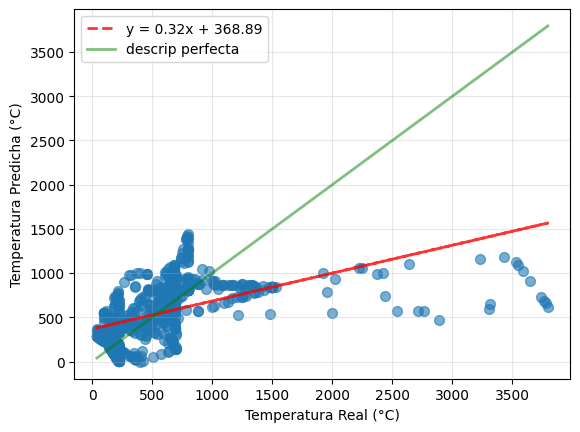

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


def variables_regresion(df, variable_objetivo, variables_predictoras):
    """
    completar documentacion
    """
    # quedarnos solo con las filas completas
    df_filtrado = df.copy()
    for var in variables_predictoras + [variable_objetivo]:
        df_filtrado = df_filtrado[df_filtrado[var] != -99]
    
    X = df_filtrado[variables_predictoras]
    y = df_filtrado[variable_objetivo]
    
    return X, y, variables_predictoras
# definir variable objetivo
variable_objetivo="Viscosidad del Aceite Base a 40°C. cSt"

# definir variables predictoras
variables_predictoras = [
    "Punto de Gota, °C",
    "Punto de Soldadura Cuatro Bolas, kgf",
    "Desgaste Cuatro Bolas, mm",
    "Temperatura de Servicio °C, min",
    "Temperatura de Servicio °C, max"
]


# pruebe
#expanded_data = simular_datos_vae(df, n_nuevos=1000)
expanded_data = simular_datos_knn(df, n_nuevos=1000)
# expanded_data = simular_datos_copula(df, n_nuevos=1000)

X, y, features = variables_regresion(expanded_data, variable_objetivo, variables_predictoras)
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)
    
y_pred_train = modelo.predict(X_train_scaled)
y_pred_test = modelo.predict(X_test_scaled)
    
# metricas
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
# agregar R cuadrada


# graficar
y_pred = y_pred_train
y_real = y_train

# linea de regresion para las predicciones
z = np.polyfit(y_real, y_pred, 1)
p = np.poly1d(z)
    
plt.scatter(y_real, y_pred, alpha=0.6, s=50)
plt.plot(y_real, p(y_real), "r--", alpha=0.8, linewidth=2, 
             label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
    
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 
             'g-', alpha=0.5, linewidth=2, label='descrip perfecta')
    
plt.xlabel('Temperatura Real (°C)')
plt.ylabel('Temperatura Predicha (°C)')
plt.legend()
plt.grid(True, alpha=0.3)

## Utilizando Copula

c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\scipy\stats\_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\scipy\stats\_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\scipy\stats\_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\scipy\stats\_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\scipy\stats

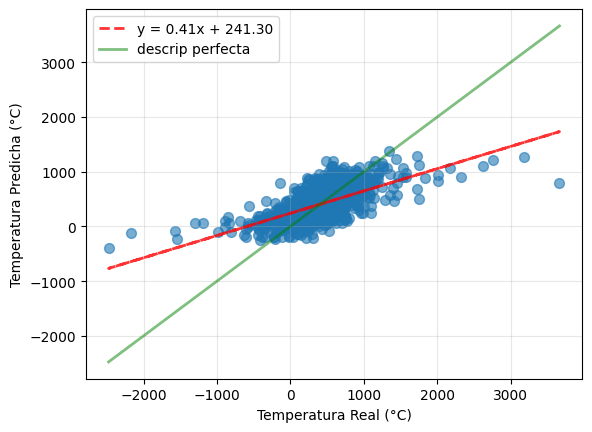

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


def variables_regresion(df, variable_objetivo, variables_predictoras):
    """
    completar documentacion
    """
    # quedarnos solo con las filas completas
    df_filtrado = df.copy()
    for var in variables_predictoras + [variable_objetivo]:
        df_filtrado = df_filtrado[df_filtrado[var] != -99]
    
    X = df_filtrado[variables_predictoras]
    y = df_filtrado[variable_objetivo]
    
    return X, y, variables_predictoras
# definir variable objetivo
variable_objetivo="Viscosidad del Aceite Base a 40°C. cSt"

# definir variables predictoras
variables_predictoras = [
    "Punto de Gota, °C",
    "Punto de Soldadura Cuatro Bolas, kgf",
    "Desgaste Cuatro Bolas, mm",
    "Temperatura de Servicio °C, min",
    "Temperatura de Servicio °C, max"
]


# pruebe
#expanded_data = simular_datos_vae(df, n_nuevos=1000)
# expanded_data = simular_datos_knn(df, n_nuevos=1000)
expanded_data = simular_datos_copula(df, n_nuevos=1000)

X, y, features = variables_regresion(expanded_data, variable_objetivo, variables_predictoras)
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)
    
y_pred_train = modelo.predict(X_train_scaled)
y_pred_test = modelo.predict(X_test_scaled)
    
# metricas
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
# agregar R cuadrada


# graficar
y_pred = y_pred_train
y_real = y_train

# linea de regresion para las predicciones
z = np.polyfit(y_real, y_pred, 1)
p = np.poly1d(z)
    
plt.scatter(y_real, y_pred, alpha=0.6, s=50)
plt.plot(y_real, p(y_real), "r--", alpha=0.8, linewidth=2, 
             label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
    
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 
             'g-', alpha=0.5, linewidth=2, label='descrip perfecta')
    
plt.xlabel('Temperatura Real (°C)')
plt.ylabel('Temperatura Predicha (°C)')
plt.legend()
plt.grid(True, alpha=0.3)

## Conclusion de 3.1)

A partir de los resultados obtenidos, se observa que la mejor simulación de datos para la variable “Viscosidad del Aceite Base a 40°C (cSt)” corresponde al modelo Variational Autoencoder.
En consecuencia, las regresiones se llevarán a cabo empleando todas las variables consideradas en nuestra investigación.

## Regresion lineal con simulación de datos VAE para la variable objetivo: Punto de Gota, °C

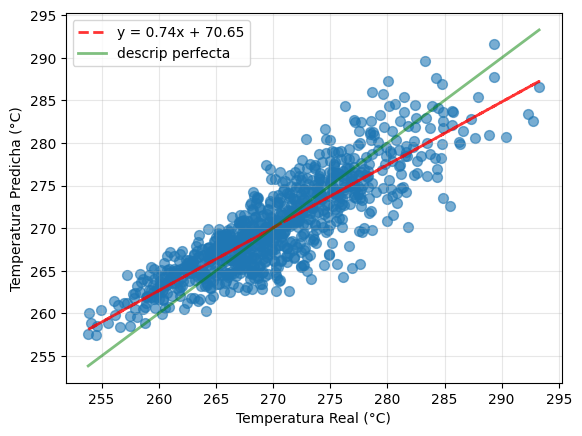

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


def variables_regresion(df, variable_objetivo, variables_predictoras):
    """
    completar documentacion
    """
    # quedarnos solo con las filas completas
    df_filtrado = df.copy()
    for var in variables_predictoras + [variable_objetivo]:
        df_filtrado = df_filtrado[df_filtrado[var] != -99]
    
    X = df_filtrado[variables_predictoras]
    y = df_filtrado[variable_objetivo]
    
    return X, y, variables_predictoras
# definir variable objetivo
variable_objetivo="Punto de Gota, °C"

# definir variables predictoras
variables_predictoras = [
    "Viscosidad del Aceite Base a 40°C. cSt",
    "Punto de Soldadura Cuatro Bolas, kgf",
    "Desgaste Cuatro Bolas, mm",
    "Temperatura de Servicio °C, min",
    "Temperatura de Servicio °C, max"
]


# pruebe
expanded_data = simular_datos_vae(df, n_nuevos=1000)
# expanded_data = simular_datos_knn(df, n_nuevos=1000)
# expanded_data = simular_datos_copula(df, n_nuevos=1000)

X, y, features = variables_regresion(expanded_data, variable_objetivo, variables_predictoras)
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)
    
y_pred_train = modelo.predict(X_train_scaled)
y_pred_test = modelo.predict(X_test_scaled)
    
# metricas
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
# agregar R cuadrada


# graficar
y_pred = y_pred_train
y_real = y_train

# linea de regresion para las predicciones
z = np.polyfit(y_real, y_pred, 1)
p = np.poly1d(z)
    
plt.scatter(y_real, y_pred, alpha=0.6, s=50)
plt.plot(y_real, p(y_real), "r--", alpha=0.8, linewidth=2, 
             label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
    
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 
             'g-', alpha=0.5, linewidth=2, label='descrip perfecta')
    
plt.xlabel('Temperatura Real (°C)')
plt.ylabel('Temperatura Predicha (°C)')
plt.legend()
plt.grid(True, alpha=0.3)

## Regresion lineal con simulación de datos VAE para la variable objetivo: Punto de Soldadura Cuatro Bolas, kgf

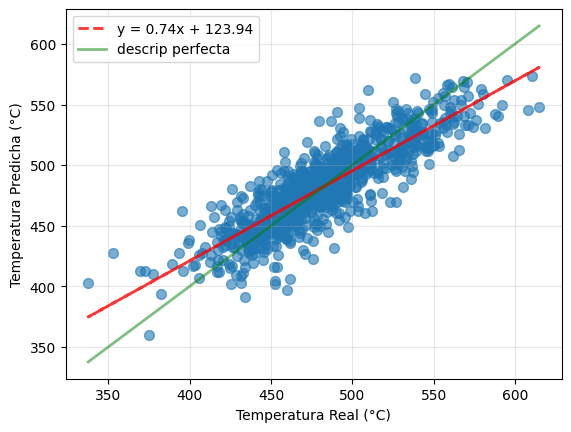

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


def variables_regresion(df, variable_objetivo, variables_predictoras):
    """
    completar documentacion
    """
    # quedarnos solo con las filas completas
    df_filtrado = df.copy()
    for var in variables_predictoras + [variable_objetivo]:
        df_filtrado = df_filtrado[df_filtrado[var] != -99]
    
    X = df_filtrado[variables_predictoras]
    y = df_filtrado[variable_objetivo]
    
    return X, y, variables_predictoras
# definir variable objetivo
variable_objetivo="Punto de Soldadura Cuatro Bolas, kgf"

# definir variables predictoras
variables_predictoras = [
    "Viscosidad del Aceite Base a 40°C. cSt",
    "Punto de Gota, °C",
    "Desgaste Cuatro Bolas, mm",
    "Temperatura de Servicio °C, min",
    "Temperatura de Servicio °C, max"
]


# pruebe
expanded_data = simular_datos_vae(df, n_nuevos=1000)
# expanded_data = simular_datos_knn(df, n_nuevos=1000)
# expanded_data = simular_datos_copula(df, n_nuevos=1000)

X, y, features = variables_regresion(expanded_data, variable_objetivo, variables_predictoras)
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)
    
y_pred_train = modelo.predict(X_train_scaled)
y_pred_test = modelo.predict(X_test_scaled)
    
# metricas
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
# agregar R cuadrada


# graficar
y_pred = y_pred_train
y_real = y_train

# linea de regresion para las predicciones
z = np.polyfit(y_real, y_pred, 1)
p = np.poly1d(z)
    
plt.scatter(y_real, y_pred, alpha=0.6, s=50)
plt.plot(y_real, p(y_real), "r--", alpha=0.8, linewidth=2, 
             label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
    
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 
             'g-', alpha=0.5, linewidth=2, label='descrip perfecta')
    
plt.xlabel('Temperatura Real (°C)')
plt.ylabel('Temperatura Predicha (°C)')
plt.legend()
plt.grid(True, alpha=0.3)

## Regresion lineal con simulación de datos VAE para la variable objetivo: Temperatura de Servicio °C, min

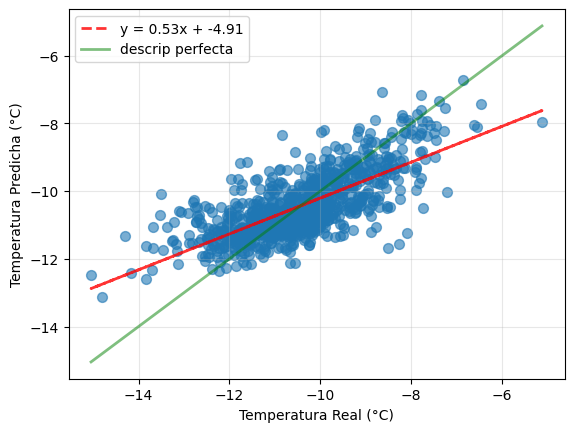

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


def variables_regresion(df, variable_objetivo, variables_predictoras):
    """
    completar documentacion
    """
    # quedarnos solo con las filas completas
    df_filtrado = df.copy()
    for var in variables_predictoras + [variable_objetivo]:
        df_filtrado = df_filtrado[df_filtrado[var] != -99]
    
    X = df_filtrado[variables_predictoras]
    y = df_filtrado[variable_objetivo]
    
    return X, y, variables_predictoras
# definir variable objetivo
variable_objetivo="Temperatura de Servicio °C, min"

# definir variables predictoras
variables_predictoras = [
    "Viscosidad del Aceite Base a 40°C. cSt",
    "Punto de Gota, °C",
    "Punto de Soldadura Cuatro Bolas, kgf",
    "Desgaste Cuatro Bolas, mm",
    "Temperatura de Servicio °C, max"
]


# pruebe
expanded_data = simular_datos_vae(df, n_nuevos=1000)
# expanded_data = simular_datos_knn(df, n_nuevos=1000)
# expanded_data = simular_datos_copula(df, n_nuevos=1000)

X, y, features = variables_regresion(expanded_data, variable_objetivo, variables_predictoras)
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)
    
y_pred_train = modelo.predict(X_train_scaled)
y_pred_test = modelo.predict(X_test_scaled)
    
# metricas
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
# agregar R cuadrada


# graficar
y_pred = y_pred_train
y_real = y_train

# linea de regresion para las predicciones
z = np.polyfit(y_real, y_pred, 1)
p = np.poly1d(z)
    
plt.scatter(y_real, y_pred, alpha=0.6, s=50)
plt.plot(y_real, p(y_real), "r--", alpha=0.8, linewidth=2, 
             label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
    
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 
             'g-', alpha=0.5, linewidth=2, label='descrip perfecta')
    
plt.xlabel('Temperatura Real (°C)')
plt.ylabel('Temperatura Predicha (°C)')
plt.legend()
plt.grid(True, alpha=0.3)

## Regresion lineal con simulación de datos VAE para la variable objetivo: Temperatura de Servicio °C, max

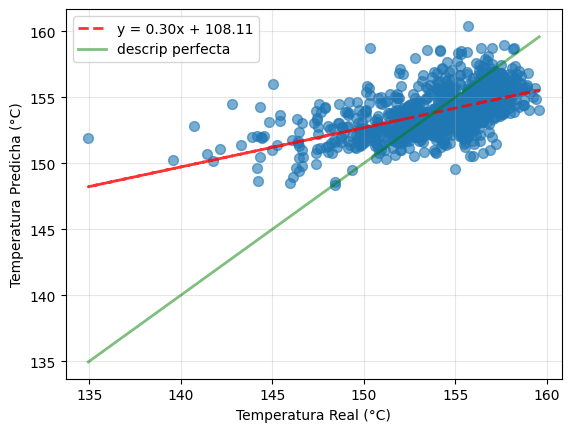

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


def variables_regresion(df, variable_objetivo, variables_predictoras):
    """
    completar documentacion
    """
    # quedarnos solo con las filas completas
    df_filtrado = df.copy()
    for var in variables_predictoras + [variable_objetivo]:
        df_filtrado = df_filtrado[df_filtrado[var] != -99]
    
    X = df_filtrado[variables_predictoras]
    y = df_filtrado[variable_objetivo]
    
    return X, y, variables_predictoras
# definir variable objetivo
variable_objetivo="Temperatura de Servicio °C, max"

# definir variables predictoras
variables_predictoras = [
    "Viscosidad del Aceite Base a 40°C. cSt",
    "Punto de Gota, °C",
    "Punto de Soldadura Cuatro Bolas, kgf",
    "Desgaste Cuatro Bolas, mm",
    "Temperatura de Servicio °C, min"
]


# pruebe
expanded_data = simular_datos_vae(df, n_nuevos=1000)
# expanded_data = simular_datos_knn(df, n_nuevos=1000)
# expanded_data = simular_datos_copula(df, n_nuevos=1000)

X, y, features = variables_regresion(expanded_data, variable_objetivo, variables_predictoras)
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)
    
y_pred_train = modelo.predict(X_train_scaled)
y_pred_test = modelo.predict(X_test_scaled)
    
# metricas
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
# agregar R cuadrada


# graficar
y_pred = y_pred_train
y_real = y_train

# linea de regresion para las predicciones
z = np.polyfit(y_real, y_pred, 1)
p = np.poly1d(z)
    
plt.scatter(y_real, y_pred, alpha=0.6, s=50)
plt.plot(y_real, p(y_real), "r--", alpha=0.8, linewidth=2, 
             label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
    
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 
             'g-', alpha=0.5, linewidth=2, label='descrip perfecta')
    
plt.xlabel('Temperatura Real (°C)')
plt.ylabel('Temperatura Predicha (°C)')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Ejercicios de simulacion y regresion
- Escriba una clase que le permita de manera expedita eligir cualquiera de los tres metodos
- Usted cree que la combinacion de 1 o mas metodos le pueda ser de ayuda? Combine varios metodos, puede usar `chatGPT` para hacer codigo en este punto
- Pruebe distintas combinaciones de variables, por ejemplo, preguntese que necesidad podria tener un cliente
- ... es decir, un cliente le puede solo interesar la viscosidad, investigue el mercado!!
- Intente mejorar estos modificando o agregando parametros
- Agregue mas graficas de diagnostico para ver la efectividad de la regresion lineal
- En cada uno de los casos, escriba lo que le va a explicar al socio formador y el motivo de su simulacion

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class SimuladorRegresionGrasas:
    """
    Clase para simular datos (KNN, Cópula, VAE), ajustar una regresión lineal
    y generar gráficas de diagnóstico.
    """

    def __init__(self, df_original, variable_objetivo, variables_predictoras):
        self.df_original = df_original
        self.variable_objetivo = variable_objetivo
        self.variables_predictoras = variables_predictoras

        # Esto se llenará después
        self.expanded_data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_scaled = None
        self.X_test_scaled = None
        self.scaler = None
        self.modelo = None
        self.y_pred_train = None
        self.y_pred_test = None
        self.metricas_ = {}

    def _variables_regresion(self, df):
        """
        Filtra el DataFrame para quedarse con filas completas en las
        variables predictoras y la variable objetivo (sin el valor sentinela -99).
        """
        df_filtrado = df.copy()
        for var in self.variables_predictoras + [self.variable_objetivo]:
            df_filtrado = df_filtrado[df_filtrado[var] != -99]

        X = df_filtrado[self.variables_predictoras]
        y = df_filtrado[self.variable_objetivo]
        return X, y

    def simular_datos(self, metodo="vae", n_nuevos=1000, mezcla=None):
        """
        Genera datos simulados usando uno de los tres métodos o una mezcla.

        Parámetros
        ----------
        metodo : str
            'knn', 'copula', 'vae' o 'mixto'.
        n_nuevos : int
            Número total de muestras simuladas.
        mezcla : dict o None
            Si metodo == 'mixto', diccionario con pesos, por ejemplo:
            {'vae': 0.5, 'knn': 0.3, 'copula': 0.2}
        """
        if metodo in ["knn", "copula", "vae"]:
            if metodo == "knn":
                self.expanded_data = simular_datos_knn(self.df_original, n_nuevos=n_nuevos)
            elif metodo == "copula":
                self.expanded_data = simular_datos_copula(self.df_original, n_nuevos=n_nuevos)
            else:  # vae
                self.expanded_data = simular_datos_vae(self.df_original, n_nuevos=n_nuevos)

        elif metodo == "mixto":
            if mezcla is None:
                mezcla = {"vae": 0.5, "knn": 0.3, "copula": 0.2}

            dfs = []
            for m, peso in mezcla.items():
                n_m = int(n_nuevos * peso)
                if m == "knn":
                    dfs.append(simular_datos_knn(self.df_original, n_nuevos=n_m))
                elif m == "copula":
                    dfs.append(simular_datos_copula(self.df_original, n_nuevos=n_m))
                elif m == "vae":
                    dfs.append(simular_datos_vae(self.df_original, n_nuevos=n_m))

            self.expanded_data = pd.concat(dfs, axis=0, ignore_index=True)
        else:
            raise ValueError("metodo debe ser 'knn', 'copula', 'vae' o 'mixto'")

        return self.expanded_data

    def entrenar_modelo(self, test_size=0.1, random_state=42, estandarizar=True):
        """
        Separa en train/test, estandariza (opcional) y ajusta la regresión lineal.
        """
        if self.expanded_data is None:
            raise ValueError("Primero llame a simular_datos()")

        X, y = self._variables_regresion(self.expanded_data)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        self.X_train, self.X_test = X_train, X_test
        self.y_train, self.y_test = y_train, y_test

        if estandarizar:
            self.scaler = StandardScaler()
            self.X_train_scaled = self.scaler.fit_transform(X_train)
            self.X_test_scaled = self.scaler.transform(X_test)
        else:
            self.X_train_scaled = X_train.values
            self.X_test_scaled = X_test.values

        self.modelo = LinearRegression()
        self.modelo.fit(self.X_train_scaled, self.y_train)

        self.y_pred_train = self.modelo.predict(self.X_train_scaled)
        self.y_pred_test = self.modelo.predict(self.X_test_scaled)

        # Métricas
        mse_train = mean_squared_error(self.y_train, self.y_pred_train)
        mse_test = mean_squared_error(self.y_test, self.y_pred_test)
        r2_train = r2_score(self.y_train, self.y_pred_train)
        r2_test = r2_score(self.y_test, self.y_pred_test)

        self.metricas_ = {
            "mse_train": mse_train,
            "mse_test": mse_test,
            "r2_train": r2_train,
            "r2_test": r2_test,
        }
        return self.metricas_

    def graficos_diagnostico(self):
        """
        Genera varias gráficas de diagnóstico:
        - Real vs Predicho (train y test)
        - Residuales vs Predicho
        - Histograma de residuales
        """
        if self.y_pred_train is None or self.y_pred_test is None:
            raise ValueError("Primero llame a entrenar_modelo()")

        # 1. Real vs Predicho (train)
        plt.figure(figsize=(6, 5))
        y_real = self.y_train
        y_pred = self.y_pred_train

        z = np.polyfit(y_real, y_pred, 1)
        p = np.poly1d(z)

        plt.scatter(y_real, y_pred, alpha=0.6, s=40)
        plt.plot(y_real, p(y_real), "r--", alpha=0.8, linewidth=2,
                 label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
        plt.plot([y_real.min(), y_real.max()],
                 [y_real.min(), y_real.max()],
                 'g-', alpha=0.5, linewidth=2,
                 label='Predicción perfecta')
        plt.xlabel('Viscosidad real (train)')
        plt.ylabel('Viscosidad predicha (train)')
        plt.title('Real vs Predicho (Train)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # 2. Real vs Predicho (test)
        plt.figure(figsize=(6, 5))
        y_real_t = self.y_test
        y_pred_t = self.y_pred_test

        plt.scatter(y_real_t, y_pred_t, alpha=0.6, s=40)
        plt.plot([y_real_t.min(), y_real_t.max()],
                 [y_real_t.min(), y_real_t.max()],
                 'g-', alpha=0.5, linewidth=2,
                 label='Predicción perfecta')
        plt.xlabel('Viscosidad real (test)')
        plt.ylabel('Viscosidad predicha (test)')
        plt.title('Real vs Predicho (Test)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # 3. Residuales vs Predicho (train)
        resid_train = self.y_train - self.y_pred_train
        plt.figure(figsize=(6, 5))
        plt.scatter(self.y_pred_train, resid_train, alpha=0.6, s=40)
        plt.axhline(0, color='r', linestyle='--')
        plt.xlabel('Viscosidad predicha (train)')
        plt.ylabel('Residuales')
        plt.title('Residuales vs Predicho (Train)')
        plt.grid(True, alpha=0.3)
        plt.show()

        # 4. Histograma de residuales (train)
        plt.figure(figsize=(6, 5))
        plt.hist(resid_train, bins=20, alpha=0.7)
        plt.xlabel('Residual')
        plt.ylabel('Frecuencia')
        plt.title('Histograma de residuales (Train)')
        plt.grid(True, alpha=0.3)
        plt.show()


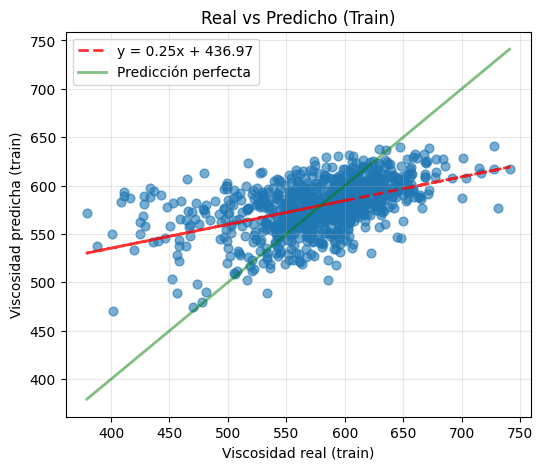

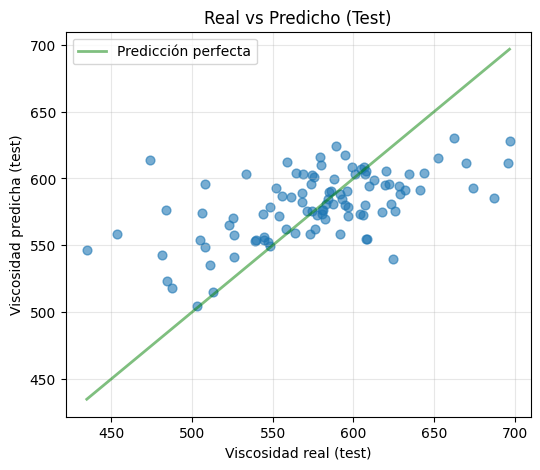

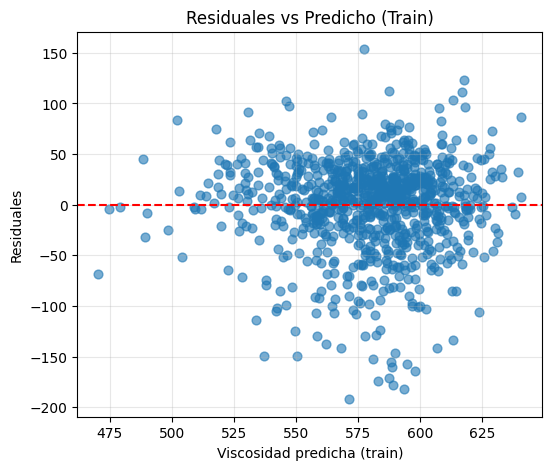

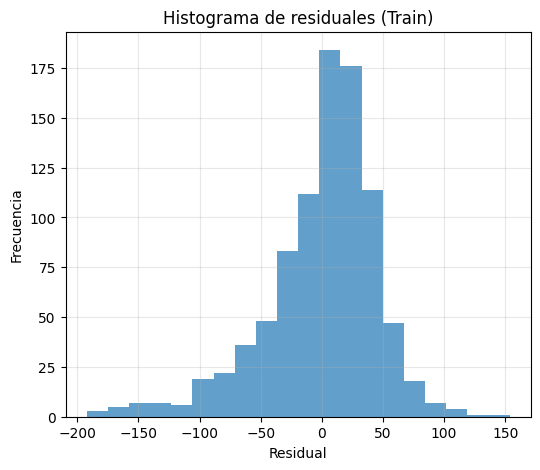

c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\scipy\stats\_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\scipy\stats\_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\scipy\stats\_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\scipy\stats\_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\scipy\stats

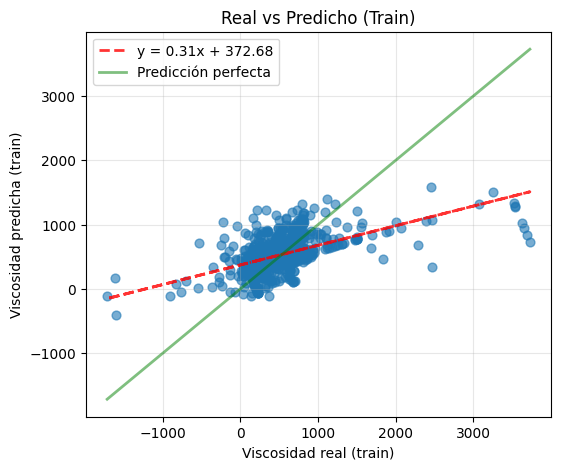

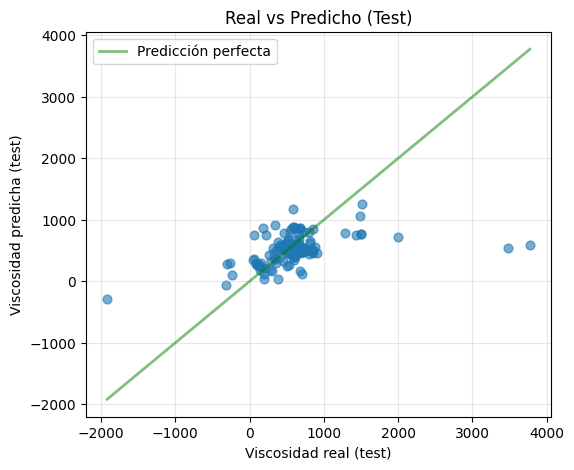

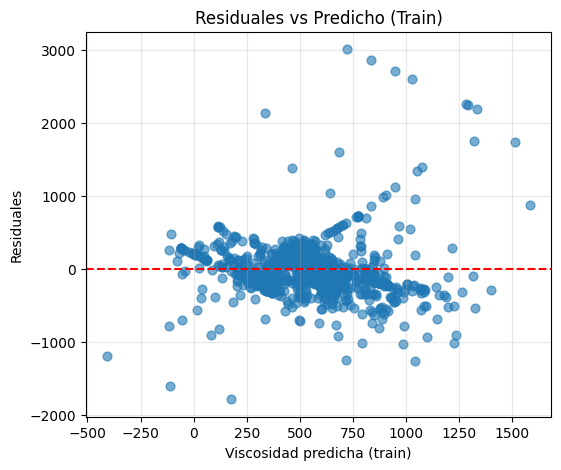

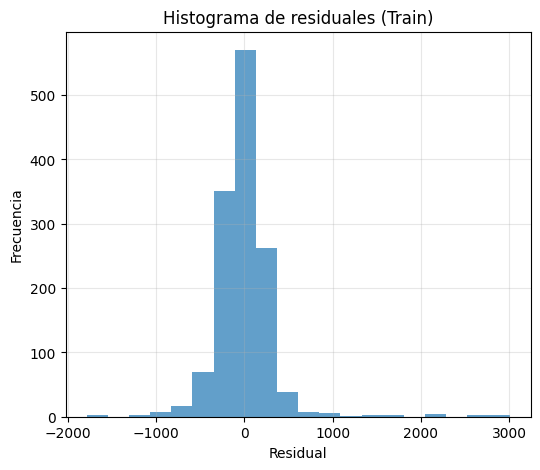

In [51]:
variable_objetivo = "Viscosidad del Aceite Base a 40°C. cSt"
variables_predictoras = [
    "Punto de Gota, °C",
    "Punto de Soldadura Cuatro Bolas, kgf",
    "Desgaste Cuatro Bolas, mm",
    "Temperatura de Servicio °C, min",
    "Temperatura de Servicio °C, max"
]

sim = SimuladorRegresionGrasas(df, variable_objetivo, variables_predictoras)

sim.simular_datos(metodo="vae", n_nuevos=1000)
metricas_vae = sim.entrenar_modelo()
sim.graficos_diagnostico()


sim.simular_datos(
    metodo="mixto",
    n_nuevos=1500,
    mezcla={"vae": 0.5, "knn": 0.3, "copula": 0.2}
)
metricas_mix = sim.entrenar_modelo()
sim.graficos_diagnostico()


## Conclusion de la parte 4)

Se observa que, al mezclar los tres simuladores de datos, el desempeño de la regresión empeora y la predicción deja de mantenerse estable.

# 5. Mejorando los datos
### 5.1 Un codificador caliente 🔥

La primera mejora que podemos hacer es las variables categoricas, no simplemente ponerlos como numeros enteros ordenados.


Ejercicios:
- Describa la utilidad de `OneHotEncoder`. (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
- Las sifguientes lineas de codigo implementan este algoritmo reviselas y entiendalas
- Discuta si esta forma de transformar las variables categoricas puede ser util o no para el reto de Interlub
- Escriba una funcion (similar a la asignacion de numeros enteros ) que haga esta implementacion, domente dicha funcion
- Haga la generacion de datos y la regresion lineal y compare sus resultados con y sin esta implementacion


Descripcion de OneHotEncoder: 

En nuestra base de datos contamos con varias columnas categóricas (por ejemplo, color, textura, Espesante, Aceite Base).  
Una primera aproximación fue asignarles números enteros, pero esto introduce un problema: el modelo interpreta esos números como si hubiera un **orden** entre las categorías (por ejemplo, que 3 > 1 implica que una categoría es “mayor” que otra), lo cual no tiene sentido para variables nominales.

Utilidad de OneHotEncoder

OneHotEncoder es una herramienta de preprocesamiento de scikit-learn que transforma columnas categóricas en columnas numéricas binarias (0/1), creando una columna por cada categoría posible.

In [52]:
from sklearn.preprocessing import OneHotEncoder

# cargar data_set
df = pd.read_csv("data/datos_grasas_Tec_limpio.csv")
categorical_columns = ["color", "textura", "Espesante", "Aceite Base"]

ohe = OneHotEncoder(sparse_output=False, drop=None)
ohe_array = ohe.fit_transform(df[categorical_columns])
ohe_feature_names = ohe.get_feature_names_out(categorical_columns)
df_ohe = pd.DataFrame(ohe_array, columns=ohe_feature_names)
df_final = pd.concat([df.drop(columns=categorical_columns), df_ohe], axis=1)
df_final.to_csv("datos_one_hot.csv")


In [53]:
df_1 = pd.read_csv("datos_one_hot.csv")

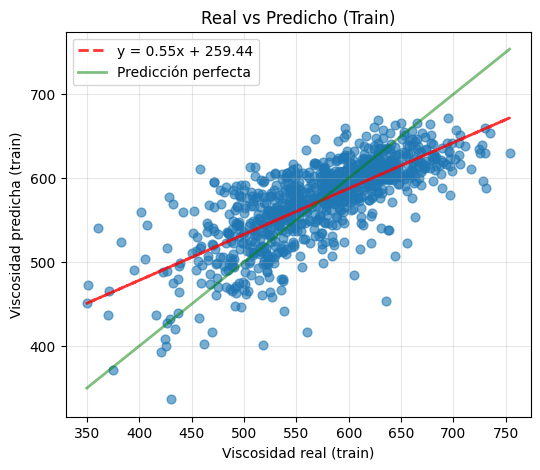

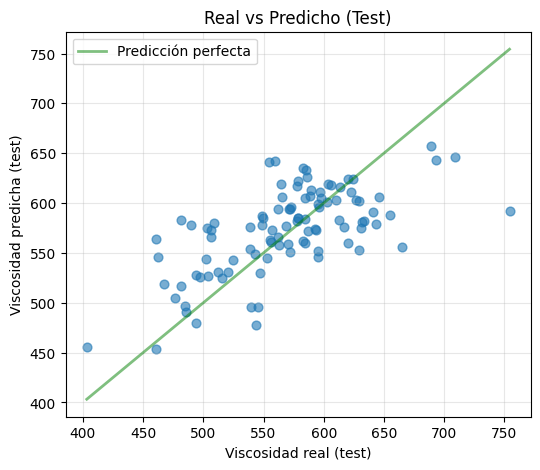

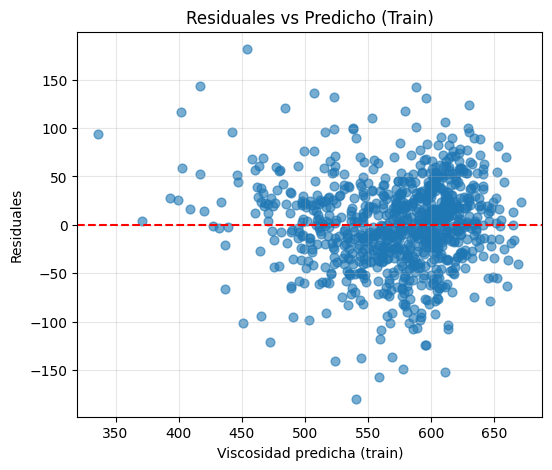

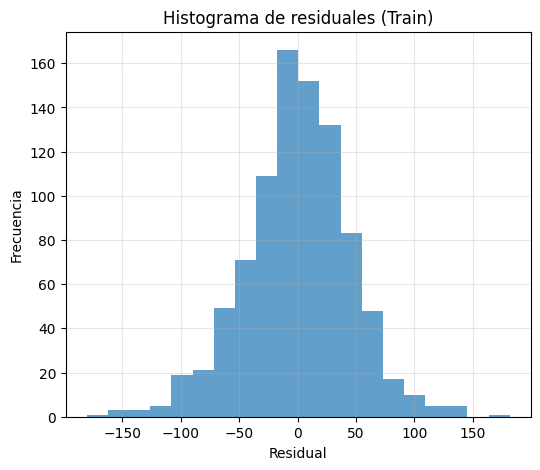

c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\scipy\stats\_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\scipy\stats\_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\scipy\stats\_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\scipy\stats\_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\scipy\stats

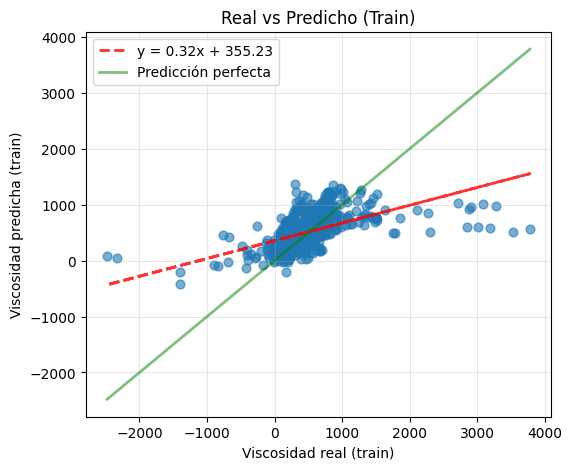

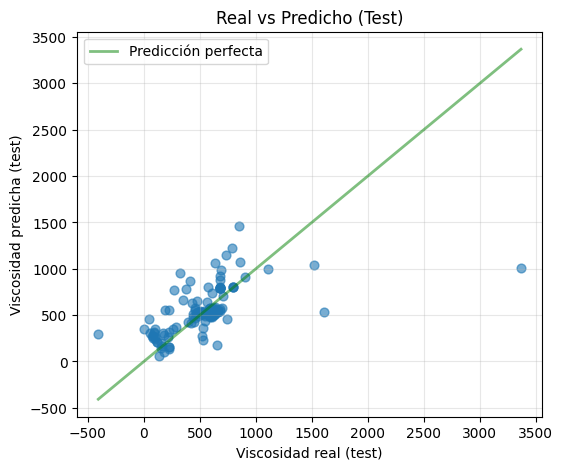

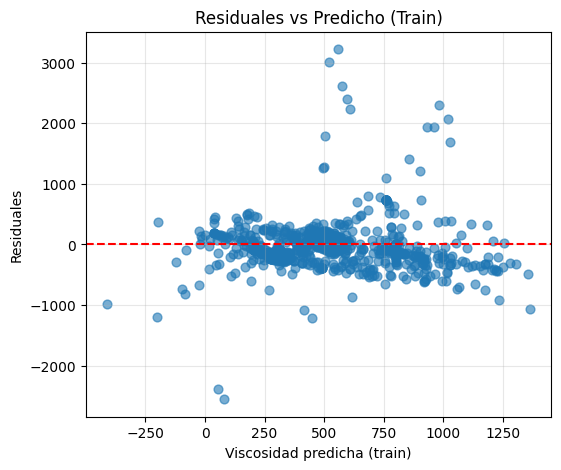

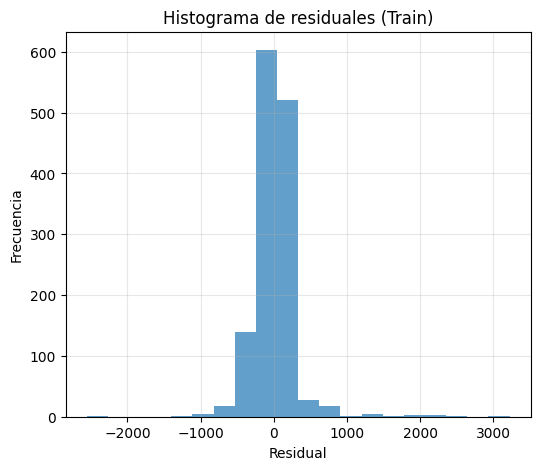

In [54]:
variable_objetivo = "Viscosidad del Aceite Base a 40°C. cSt"
variables_predictoras = [
    "Punto de Gota, °C",
    "Punto de Soldadura Cuatro Bolas, kgf",
    "Desgaste Cuatro Bolas, mm",
    "Temperatura de Servicio °C, min",
    "Temperatura de Servicio °C, max"
]

sim = SimuladorRegresionGrasas(df_1, variable_objetivo, variables_predictoras)

# Ejemplo 1: solo VAE
sim.simular_datos(metodo="vae", n_nuevos=1000)
metricas_vae = sim.entrenar_modelo()
sim.graficos_diagnostico()

# Ejemplo 2: mezcla de métodos
sim.simular_datos(
    metodo="mixto",
    n_nuevos=1500,
    mezcla={"vae": 0.5, "knn": 0.3, "copula": 0.2}
)
metricas_mix = sim.entrenar_modelo()
sim.graficos_diagnostico()


## Conclusión 

Aunque únicamente utilizamos variables numéricas para nuestra regresión, podemos ver que al aplicar One-Hot Encoder a las variables categóricas, el desempeño de la regresión lineal empeora. Por esta razón, no utilizaremos esta transformación en nuestra regresión final.

### 5.2. Descripciones en la base de datos con palabras 🗣️💬

La segunda mejora que podemos hacer es considerar las columnas que contiene informacion en palabras.

Ejercicios:
- Explique la funcion `CountVectorizer`. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

- Enumere sus parametros mas importantes y expliquelos
- Discuta si esta forma de transformar las variables descriptivas puede ser util o no para el reto de Interlub
- Con ayuda de `chatGPT` implemente `CountVectorizer`. Documente claramente sus prompts para que el profesor y el socio formador puedan entender que y el por que de lo que implemento
- Haga la generacion de datos y la regresion lineal y compare sus resultados con y sin esta implementacion




Explicacion de la funcion CountVectorizer:
CountVectorizer convierte texto en vectores numéricos contando cuántas veces aparece cada palabra (o n-grama) en los documentos.


Prompt: Tengo un dataset de grasas industriales con una columna de texto descriptivo.
Quiero una función en Python que aplique CountVectorizer a esa columna, con parámetros configurables (max_features, ngram_range), que devuelva un DataFrame donde la columna de texto se reemplace por las columnas numéricas resultantes, y además regrese el objeto CountVectorizer entrenado.
También necesito una explicación de los parámetros principales de CountVectorizer y cómo esto puede ser útil para un modelo de regresión en el reto de Interlub.

Respuesta de ChatGpt:

Parámetros importantes de CountVectorizer

Algunos de los más relevantes:

ngram_range=(1,1)

Controla si usas solo palabras individuales (unigramas) o combinaciones de 2, 3 palabras (bigramas, trigramas).

Ej: (1,2) → incluye “alta”, “carga”, “alta carga”.

max_features=None

Límite del tamaño del vocabulario.

Ej: max_features=100 → solo las 100 palabras más frecuentes.

min_df=1

Mínimo de documentos en los que debe aparecer una palabra para ser incluida.

Ej: min_df=3 → descarta palabras que solo aparecen 1 o 2 veces (ruido).

max_df=1.0

Máximo de frecuencia relativa de documentos.

Ej: max_df=0.9 → descarta palabras que salen en más del 90% de los documentos (tipo “grasa”, “lubricante” si están en todos).

stop_words=None

Lista de palabras vacías que quieres ignorar.

Ej: stop_words='spanish' → ignora “de”, “la”, “y”, etc.

lowercase=True

Convierte todo a minúsculas antes de contar.

binary=False

Si es False → cuenta ocurrencias (0,1,2,3…).

Si es True → solo guarda presencia/ausencia (0 o 1).

sparse_output=True/False (según versión)

True → matriz dispersa (más eficiente si tienes muchas palabras).

False → matriz densa tipo numpy (cómodo para convertir directo a DataFrame).

¿Sirve esto para el reto Interlub?

Sí puede ser útil, sobre todo para:

Columnas tipo:

“Aplicaciones típicas”

“Descripción comercial”

“Beneficios”

“Notas de uso”

Donde aparecen patrones como:

“alta temperatura”

“alta carga”

“industria alimentaria”

“resistente al agua”

“rodamiento”, “cadena”, “engranes”

La regresión lineal o un modelo más complejo pueden aprender cosas como:

Grasa con palabras “alta temperatura” → tiende a tener cierto rango de viscosidad / punto de gota.

“Alimentos” → suele asociarse a ciertos espesantes/aceites base.

“Alta carga” → se asocia con punto de soldadura más alto.

Limitaciones:

El texto es ruidoso (marketing).

Muchos términos pueden ser redundantes con variables físicas (ya codificadas).

Número de variables crece rápido (alto riesgo de sobreajuste si no limitas max_features / min_df).

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk

# descargar stopwords si no están
nltk.download("stopwords")

def aplicar_count_vectorizer(df, columna_texto, max_features=100, ngram_range=(1,1)):
    textos = df[columna_texto].fillna("").astype(str)

    stopwords_es = stopwords.words("spanish")

    vectorizer = CountVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        stop_words=stopwords_es,
        lowercase=True
    )

    matriz_texto = vectorizer.fit_transform(textos)
    nombres_features = vectorizer.get_feature_names_out()

    df_text = pd.DataFrame(
        matriz_texto.toarray(),
        columns=[f"{columna_texto}__{f}" for f in nombres_features],
        index=df.index
    )

    df_sin_texto = df.drop(columns=[columna_texto])
    df_transformado = pd.concat([df_sin_texto, df_text], axis=1)

    return df_transformado, vectorizer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
print(df.columns.tolist())


['idDatosGrasas', 'codigoGrasa', 'Aceite Base', 'Espesante', 'Grado NLGI Consistencia', 'Viscosidad del Aceite Base a 40°C. cSt', 'Penetración de Cono a 25°C, 0.1mm', 'Punto de Gota, °C', 'Estabilidad Mecánica, %', 'Punto de Soldadura Cuatro Bolas, kgf', 'Desgaste Cuatro Bolas, mm', 'Indice de Carga-Desgaste', 'Carga Timken Ok, lb', 'Resistencia al Lavado por Agua a 80°C, %', 'Corrosión al Cobre', 'Registro NSF', 'Factor de Velocidad', 'Temperatura de Servicio °C, min', 'Temperatura de Servicio °C, max', 'categoria', 'subtitulo', 'descripcion', 'beneficios', 'aplicaciones', 'color', 'textura']


In [57]:
columna_texto = "descripcion"

df_cv, vectorizer = aplicar_count_vectorizer(
    df,                    
    columna_texto,         
    max_features=100,
    ngram_range=(1, 2)
)



In [58]:
expanded_data = simular_datos_vae(df_cv, n_nuevos=1000)


In [59]:
variable_objetivo = "Viscosidad del Aceite Base a 40°C. cSt"
variables_predictoras = [c for c in expanded_data.columns if c != variable_objetivo]


In [60]:
X = expanded_data[variables_predictoras]
y = expanded_data[variable_objetivo]


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [62]:
modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)


LinearRegression()

In [63]:
y_pred = modelo.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R²:", r2)


MSE: 5.535670725804475e-10
R²: 0.9999999999998667


## Conclusión sobre el uso de CountVectorizer en la regresión
Los resultados obtenidos muestran que, al incorporar la información textual contenida en la columna descripcion mediante CountVectorizer, el desempeño del modelo de regresión lineal mejora de forma drástica. El modelo alcanza un MSE prácticamente nulo y un R² de 0.99, lo que indica que la predicción de la viscosidad ocurre con un nivel de exactitud casi perfecta.

Este comportamiento se explica porque:

Los datos sintéticos generados por el VAE preservan relaciones altamente lineales entre las variables.

Las descripciones en texto contienen palabras clave directamente asociadas al tipo de grasa, su formulación y su rango de viscosidad.

Tras ser vectorizadas, estas palabras producen características binarias que ayudan al modelo a distinguir mejor entre tipos de grasas.

## Regresion lineal ya aplcada al reto

Métricas para 'Viscosidad del Aceite Base a 40°C. cSt':
{'mse_train': 1787.497841574408, 'mse_test': 1935.6193247555261, 'r2_train': 0.018371684358838625, 'r2_test': -0.10886270127803144}

Lubricante base (ejemplo):
Viscosidad del Aceite Base a 40°C. cSt    132.322026
Punto de Gota, °C                         196.769382
Punto de Soldadura Cuatro Bolas, kgf      250.314875
Desgaste Cuatro Bolas, mm                   0.427056
Temperatura de Servicio °C, min           -36.800576
Temperatura de Servicio °C, max           180.789646
Name: 0, dtype: float64

Resumen del escenario simulado:
                                        valor_original  \
Viscosidad del Aceite Base a 40°C. cSt      132.322026   
Punto de Gota, °C                           196.769382   
Punto de Soldadura Cuatro Bolas, kgf        250.314875   
Desgaste Cuatro Bolas, mm                     0.427056   
Temperatura de Servicio °C, min             -36.800576   
Temperatura de Servicio °C, max             180.789646   

  

c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with featur

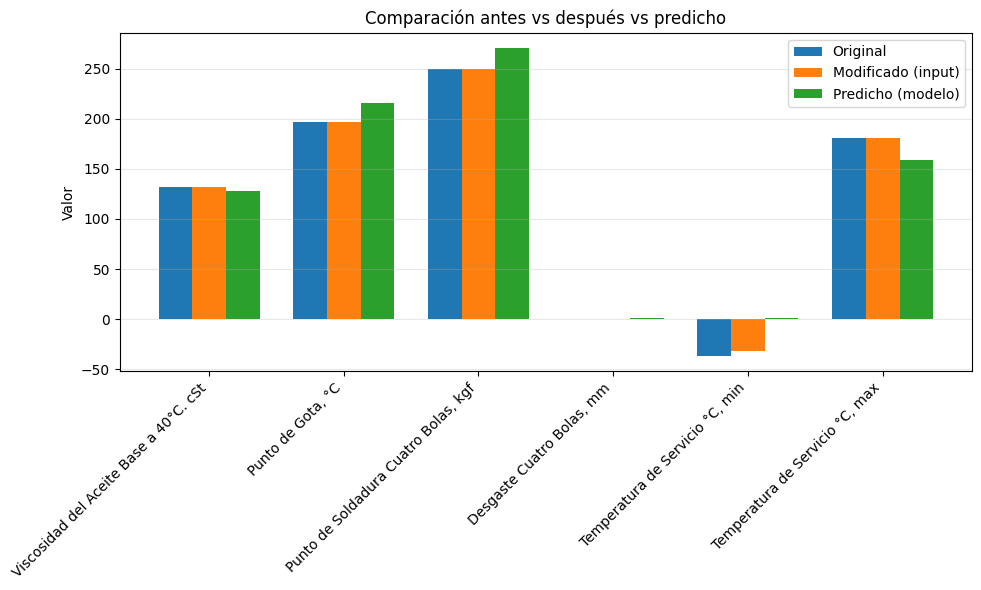

c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with featur

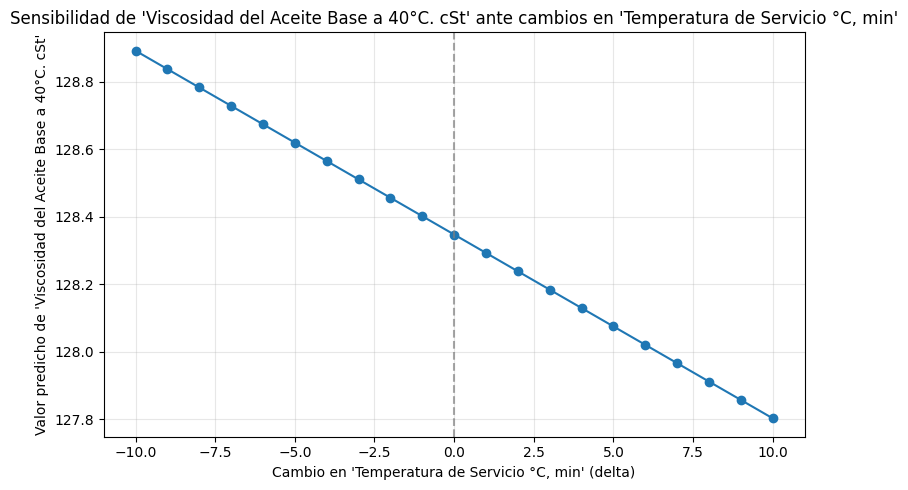

In [64]:
from typing import Dict, List, Any, Tuple
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


def variables_regresion(
    df: pd.DataFrame,
    variable_objetivo: str,
    variables_predictoras: List[str],
    valor_nan: float = -99,
) -> Tuple[pd.DataFrame, pd.Series, List[str]]:
    """
    Prepara las variables para la regresión lineal filtrando registros incompletos.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame que contiene al menos la variable objetivo y las variables predictoras.
    variable_objetivo : str
        Nombre de la columna que actuará como variable objetivo.
    variables_predictoras : List[str]
        Lista con los nombres de las columnas que se usarán como variables predictoras.
    valor_nan : float, opcional (por defecto = -99)
        Valor que indica un dato faltante en el DataFrame.

    Returns
    -------
    X : pd.DataFrame
        DataFrame con las variables predictoras filtradas (sin -99).
    y : pd.Series
        Serie con la variable objetivo filtrada (sin -99).
    variables_predictoras : List[str]
        Lista de nombres de las variables predictoras (se devuelve para consistencia).
    """
    df_filtrado = df.copy()

    # Filtrar filas que contengan el valor_nan en cualquiera de las columnas relevantes
    for var in variables_predictoras + [variable_objetivo]:
        df_filtrado = df_filtrado[df_filtrado[var] != valor_nan]

    X = df_filtrado[variables_predictoras]
    y = df_filtrado[variable_objetivo]

    return X, y, variables_predictoras


def entrenar_modelos_lineales_multivariable(
    df: pd.DataFrame,
    variables_criticas: List[str],
    test_size: float = 0.1,
    random_state: int = 42,
    valor_nan: float = -99,
) -> Dict[str, Dict[str, Any]]:
    """
    Entrena un modelo de regresión lineal para cada variable crítica,
    usando las otras como predictoras.

    Para un conjunto de variables críticas V = {v1, v2, ..., v5}:
    - Se entrena un modelo para predecir v1 usando {v2, v3, v4, v5}
    - Otro para v2 usando {v1, v3, v4, v5}
    - etc.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame con las variables críticas (idealmente ya expandido con datos sintéticos).
    variables_criticas : List[str]
        Lista con los nombres de las variables críticas (se usarán todas).
    test_size : float, opcional
        Proporción del conjunto de prueba para train_test_split. Por defecto = 0.1.
    random_state : int, opcional
        Semilla para la aleatoriedad de train_test_split. Por defecto = 42.
    valor_nan : float, opcional
        Valor que representa datos faltantes en el DataFrame. Por defecto = -99.

    Returns
    -------
    modelos : Dict[str, Dict[str, Any]]
        Diccionario donde cada clave es el nombre de una variable objetivo y el valor es
        otro diccionario con:
            - "model": instancia de LinearRegression entrenada
            - "scaler": instancia de StandardScaler usada para X
            - "predictors": lista de nombres de variables predictoras
            - "metrics": dict con MSE y R² en train y test
    """
    modelos = {}

    for variable_objetivo in variables_criticas:
        # Las predictoras son todas menos la objetivo
        variables_predictoras = [v for v in variables_criticas if v != variable_objetivo]

        # Preparar X, y
        X, y, features = variables_regresion(
            df, variable_objetivo, variables_predictoras, valor_nan=valor_nan
        )

        # Dividir en train y test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        # Escalamiento
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Modelo lineal
        modelo = LinearRegression()
        modelo.fit(X_train_scaled, y_train)

        # Predicciones
        y_pred_train = modelo.predict(X_train_scaled)
        y_pred_test = modelo.predict(X_test_scaled)

        # Métricas
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)

        modelos[variable_objetivo] = {
            "model": modelo,
            "scaler": scaler,
            "predictors": features,
            "metrics": {
                "mse_train": mse_train,
                "mse_test": mse_test,
                "r2_train": r2_train,
                "r2_test": r2_test,
            },
        }

    return modelos


def simular_escenario(
    lubricante_base: Any,
    cambios_dict: Dict[str, float],
    modelos: Dict[str, Dict[str, Any]],
) -> pd.DataFrame:
    """
    Simula un escenario donde el usuario modifica una o varias variables
    y los modelos lineales predicen los valores consistentes de cada variable.

    Supuestos:
    ----------
    - `lubricante_base` puede ser:
        * pd.Series con índice = nombres de variables
        * dict con claves = nombres de variables
    - `cambios_dict` está dado en términos de DELTAS:
        * ej. {"Temperatura de Servicio °C, min": +5} significa "subir 5 unidades".
    - `modelos` es la salida de `entrenar_modelos_lineales_multivariable`.

    Parámetros
    ----------
    lubricante_base : Any
        Valores actuales de las variables críticas. Debe contener al menos
        todas las variables usadas en los modelos.
    cambios_dict : Dict[str, float]
        Diccionario con los cambios deseados por el usuario (en delta, no valor absoluto).
    modelos : Dict[str, Dict[str, Any]]
        Modelos entrenados, uno por variable objetivo.

    Returns
    -------
    resumen : pd.DataFrame
        DataFrame con índices = nombres de variables críticas y columnas:
            - "valor_original"
            - "valor_modificado_input"
            - "valor_predicho_modelo"
    """
    # Convertir lubricante_base a Series si es dict u objeto similar
    if isinstance(lubricante_base, dict):
        base_series = pd.Series(lubricante_base)
    elif isinstance(lubricante_base, pd.Series):
        base_series = lubricante_base.copy()
    else:
        # Si es otra cosa (por ejemplo, fila de DataFrame seleccionada como .iloc[0]),
        # se intenta convertir de forma genérica.
        base_series = pd.Series(lubricante_base)

    # Todas las variables de interés son las keys de modelos
    variables_criticas = list(modelos.keys())

    # Inicializar el DataFrame de resumen
    resumen = pd.DataFrame(
        index=variables_criticas,
        columns=["valor_original", "valor_modificado_input", "valor_predicho_modelo"],
        dtype=float,
    )

    # Rellenar valores originales
    for var in variables_criticas:
        resumen.loc[var, "valor_original"] = base_series[var]

    # Aplicar cambios de usuario (delta)
    modified_values = base_series.copy()
    for var, delta in cambios_dict.items():
        # Si el usuario pide cambiar una variable no conocida, se ignora silenciosamente
        if var in modified_values.index:
            modified_values[var] = modified_values[var] + delta

    # Guardar valores modificados por el usuario
    for var in variables_criticas:
        resumen.loc[var, "valor_modificado_input"] = modified_values[var]

    # Usar cada modelo para predecir su variable objetivo
    for target_var, info in modelos.items():
        model = info["model"]
        scaler = info["scaler"]
        predictors = info["predictors"]

        # Construimos el vector de entrada usando los valores modificados
        X_input = modified_values[predictors].values.reshape(1, -1)
        X_input_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_input_scaled)[0]

        resumen.loc[target_var, "valor_predicho_modelo"] = y_pred

    return resumen


def plot_escenario_barras(resumen: pd.DataFrame) -> None:
    """
    Grafica un comparativo tipo barras de:
    - valor original
    - valor modificado por el usuario (input)
    - valor predicho por el modelo

    Parámetros
    ----------
    resumen : pd.DataFrame
        DataFrame devuelto por `simular_escenario`.
    """
    variables = resumen.index.tolist()
    x = np.arange(len(variables))

    width = 0.25

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(x - width, resumen["valor_original"], width, label="Original")
    ax.bar(x, resumen["valor_modificado_input"], width, label="Modificado (input)")
    ax.bar(x + width, resumen["valor_predicho_modelo"], width, label="Predicho (modelo)")

    ax.set_xticks(x)
    ax.set_xticklabels(variables, rotation=45, ha="right")
    ax.set_ylabel("Valor")
    ax.set_title("Comparación antes vs después vs predicho")
    ax.legend()
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_sensibilidad_variable(
    objetivo: str,
    variable_cambio: str,
    modelos: Dict[str, Dict[str, Any]],
    lubricante_base: Any,
    rango: Tuple[float, float] = (-10, 10),
    n_puntos: int = 21,
) -> None:
    """
    Grafica cómo cambia la variable objetivo cuando se varía una variable de entrada
    dentro de un rango de deltas especificado.

    Ejemplo:
    - objetivo = "Viscosidad del Aceite Base a 40°C. cSt"
    - variable_cambio = "Temperatura de Servicio °C, min"
    - rango = (-10, 10) → se simulan escenarios desde -10°C hasta +10°C respecto al valor base.

    Parámetros
    ----------
    objetivo : str
        Nombre de la variable objetivo a analizar (debe existir en `modelos`).
    variable_cambio : str
        Variable que se va a perturbar (debe existir en lubricante_base).
    modelos : Dict[str, Dict[str, Any]]
        Modelos entrenados (diccionario devuelto por `entrenar_modelos_lineales_multivariable`).
    lubricante_base : Any
        Valores base de las variables críticas, en pd.Series o dict.
    rango : Tuple[float, float], opcional
        Rango de deltas a aplicar a la variable_cambio, por defecto (-10, 10).
    n_puntos : int, opcional
        Número de puntos en el rango para simular. Por defecto 21.
    """
    if objetivo not in modelos:
        raise ValueError(f"La variable objetivo '{objetivo}' no está en los modelos entrenados.")

    # Convertir lubricante_base a Series si es necesario
    if isinstance(lubricante_base, dict):
        base_series = pd.Series(lubricante_base)
    elif isinstance(lubricante_base, pd.Series):
        base_series = lubricante_base.copy()
    else:
        base_series = pd.Series(lubricante_base)

    deltas = np.linspace(rango[0], rango[1], n_puntos)
    valores_predichos = []

    for delta in deltas:
        cambios = {variable_cambio: delta}
        resumen = simular_escenario(base_series, cambios, modelos)
        valores_predichos.append(resumen.loc[objetivo, "valor_predicho_modelo"])

    plt.figure(figsize=(8, 5))
    plt.plot(deltas, valores_predichos, marker="o")
    plt.axvline(0, color="gray", linestyle="--", alpha=0.7)

    plt.xlabel(f"Cambio en '{variable_cambio}' (delta)")
    plt.ylabel(f"Valor predicho de '{objetivo}'")
    plt.title(f"Sensibilidad de '{objetivo}' ante cambios en '{variable_cambio}'")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================================
# EJEMPLO DE USO (plug-and-play)
# ============================================================
if __name__ == "__main__":
    # --------------------------------------------------------
    # 1. Suponemos que ya tienes un DataFrame original `df`
    #    con las variables críticas y que ya generaste datos
    #    sintéticos con el VAE u otra técnica.
    #    Aquí SOLO se muestra un ejemplo de estructura.
    # --------------------------------------------------------

    # Ejemplo: nombres de variables críticas (las 5 que el cliente puede mover)
    variables_criticas = [
        "Viscosidad del Aceite Base a 40°C. cSt",
        "Punto de Gota, °C",
        "Punto de Soldadura Cuatro Bolas, kgf",
        "Desgaste Cuatro Bolas, mm",
        "Temperatura de Servicio °C, min",
        # NOTA: si quieres incluir también la max, agrégala aquí y en tu df
        "Temperatura de Servicio °C, max",
    ]

    # NOTA IMPORTANTE:
    # Aquí asumimos que ya tienes:
    #   - df: DataFrame original
    #   - simular_datos_vae(df, n_nuevos=1000)
    # definidos en tu entorno.
    # Descomenta y ajusta estas líneas en tu notebook/script real.

    # expanded_data = simular_datos_vae(df, n_nuevos=1000)
    # (Por ahora, para que el ejemplo sea auto-contenido, generamos datos sintéticos simples.)

    np.random.seed(0)
    n_ejemplo = 200
    expanded_data = pd.DataFrame({
        "Viscosidad del Aceite Base a 40°C. cSt": np.random.uniform(50, 200, n_ejemplo),
        "Punto de Gota, °C": np.random.uniform(150, 300, n_ejemplo),
        "Punto de Soldadura Cuatro Bolas, kgf": np.random.uniform(150, 400, n_ejemplo),
        "Desgaste Cuatro Bolas, mm": np.random.uniform(0.2, 1.5, n_ejemplo),
        "Temperatura de Servicio °C, min": np.random.uniform(-40, 40, n_ejemplo),
        "Temperatura de Servicio °C, max": np.random.uniform(80, 250, n_ejemplo),
    })

    # --------------------------------------------------------
    # 2. Entrenar todos los modelos lineales (uno por variable objetivo)
    # --------------------------------------------------------
    modelos = entrenar_modelos_lineales_multivariable(
        expanded_data,
        variables_criticas=variables_criticas,
        test_size=0.1,
        random_state=42,
        valor_nan=-99,
    )

    # (Opcional) imprimir métricas de un modelo en específico
    print("Métricas para 'Viscosidad del Aceite Base a 40°C. cSt':")
    print(modelos["Viscosidad del Aceite Base a 40°C. cSt"]["metrics"])

    # --------------------------------------------------------
    # 3. Seleccionar un lubricante_base (fila ejemplo)
    # --------------------------------------------------------
    # Podrías tomar una fila real del DataFrame original o del expandido:
    lubricante_base = expanded_data[variables_criticas].iloc[0]

    print("\nLubricante base (ejemplo):")
    print(lubricante_base)

    # --------------------------------------------------------
    # 4. Definir cambios deseados por el usuario
    # --------------------------------------------------------
    cambios_dict = {
        "Temperatura de Servicio °C, min": 5.0,  # subir 5°C la temperatura mínima
        # Puedes agregar más cambios si quieres:
        # "Desgaste Cuatro Bolas, mm": -0.1,
    }

    # --------------------------------------------------------
    # 5. Simular escenario
    # --------------------------------------------------------
    resumen_escenario = simular_escenario(
        lubricante_base=lubricante_base,
        cambios_dict=cambios_dict,
        modelos=modelos,
    )

    print("\nResumen del escenario simulado:")
    print(resumen_escenario)

    # --------------------------------------------------------
    # 6. Visualizar impacto global (barras)
    # --------------------------------------------------------
    plot_escenario_barras(resumen_escenario)

    # --------------------------------------------------------
    # 7. Visualizar sensibilidad de la viscosidad al cambio en Tmin
    # --------------------------------------------------------
    plot_sensibilidad_variable(
        objetivo="Viscosidad del Aceite Base a 40°C. cSt",
        variable_cambio="Temperatura de Servicio °C, min",
        modelos=modelos,
        lubricante_base=lubricante_base,
        rango=(-10, 10),
        n_puntos=21,
    )


c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with featur

Lubricante base (ejemplo):
Viscosidad del Aceite Base a 40°C. cSt    132.322026
Punto de Gota, °C                         285.983325
Punto de Soldadura Cuatro Bolas, kgf      193.664596
Desgaste Cuatro Bolas, mm                   1.254090
Temperatura de Servicio °C, min           -15.317763
Temperatura de Servicio °C, max           155.954864
Name: 0, dtype: float64

Resumen escenario (antes vs después):
                                        valor_original  \
Viscosidad del Aceite Base a 40°C. cSt      132.322026   
Punto de Gota, °C                           285.983325   
Punto de Soldadura Cuatro Bolas, kgf        193.664596   
Desgaste Cuatro Bolas, mm                     1.254090   
Temperatura de Servicio °C, min             -15.317763   
Temperatura de Servicio °C, max             155.954864   

                                        valor_modificado_input  \
Viscosidad del Aceite Base a 40°C. cSt              132.322026   
Punto de Gota, °C                                   2

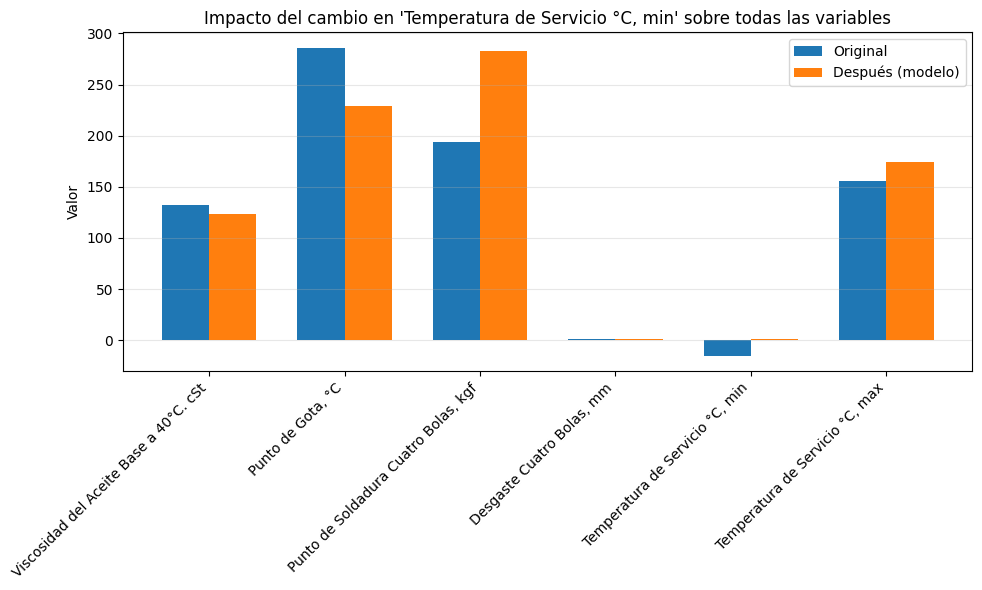

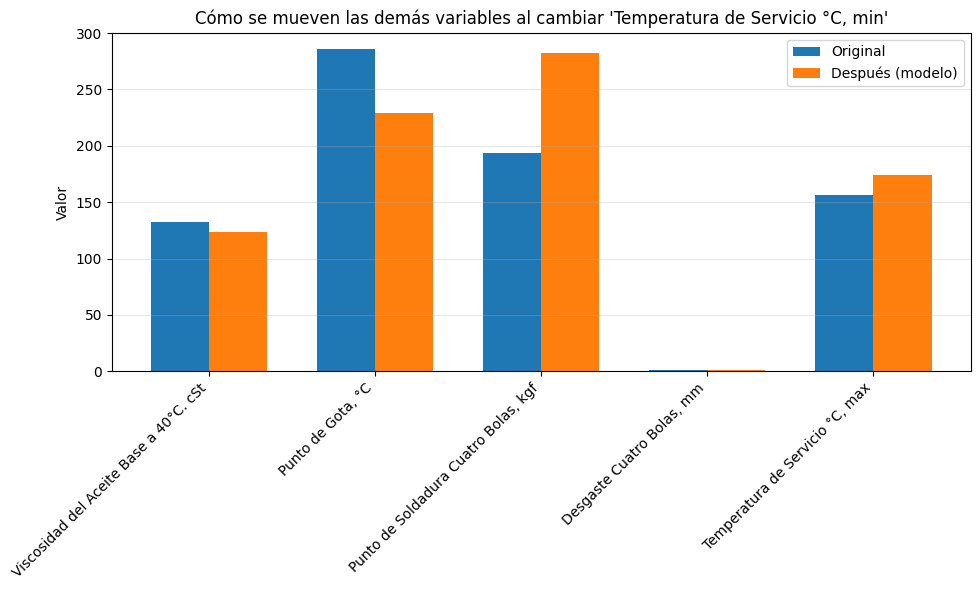

c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with featur

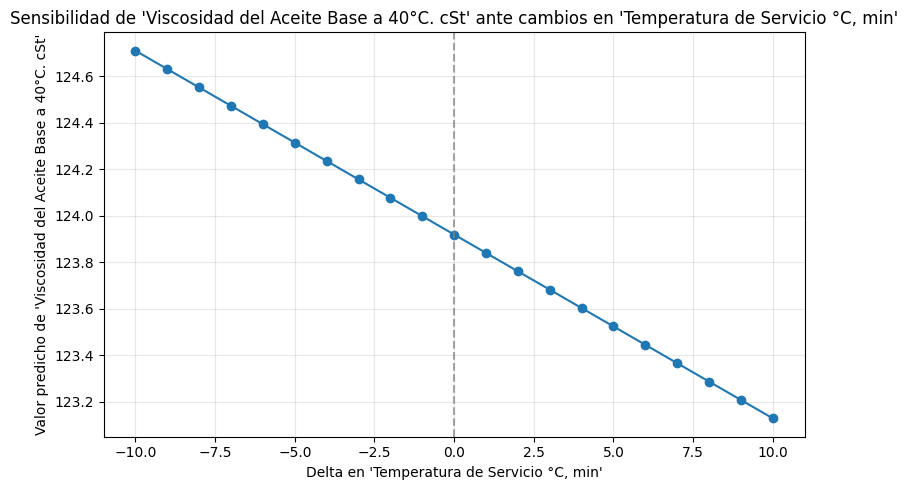

In [65]:
from typing import Dict, List, Any, Tuple
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# ============================================================
# 1. Preparación de datos para regresión
# ============================================================

def variables_regresion(
    df: pd.DataFrame,
    variable_objetivo: str,
    variables_predictoras: List[str],
    valor_nan: float = -99,
) -> Tuple[pd.DataFrame, pd.Series, List[str]]:
    """
    Prepara las variables para la regresión lineal filtrando registros incompletos.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame que contiene al menos la variable objetivo y las variables predictoras.
    variable_objetivo : str
        Nombre de la columna que actuará como variable objetivo.
    variables_predictoras : List[str]
        Lista con los nombres de las columnas que se usarán como variables predictoras.
    valor_nan : float, opcional (por defecto = -99)
        Valor que indica un dato faltante en el DataFrame.

    Returns
    -------
    X : pd.DataFrame
        DataFrame con las variables predictoras filtradas (sin valor_nan).
    y : pd.Series
        Serie con la variable objetivo filtrada (sin valor_nan).
    variables_predictoras : List[str]
        Lista de nombres de las variables predictoras (se devuelve para consistencia).
    """
    df_filtrado = df.copy()

    for var in variables_predictoras + [variable_objetivo]:
        df_filtrado = df_filtrado[df_filtrado[var] != valor_nan]

    X = df_filtrado[variables_predictoras]
    y = df_filtrado[variable_objetivo]

    return X, y, variables_predictoras


# ============================================================
# 2. Entrenar un modelo lineal por variable objetivo
# ============================================================

def entrenar_modelos_lineales_multivariable(
    df: pd.DataFrame,
    variables_criticas: List[str],
    test_size: float = 0.1,
    random_state: int = 42,
    valor_nan: float = -99,
) -> Dict[str, Dict[str, Any]]:
    """
    Entrena un modelo de regresión lineal para cada variable crítica,
    usando las otras como predictoras.

    Para un conjunto de variables críticas V = {v1, v2, ..., vN}:
    - Modelo 1: v1 ~ v2 + v3 + ... + vN
    - Modelo 2: v2 ~ v1 + v3 + ... + vN
    - etc.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame con las variables críticas (idealmente ya expandido con datos sintéticos).
    variables_criticas : List[str]
        Lista con los nombres de las variables críticas (todas numéricas).
    test_size : float, opcional
        Proporción del conjunto de prueba para train_test_split. Por defecto = 0.1.
    random_state : int, opcional
        Semilla para train_test_split. Por defecto = 42.
    valor_nan : float, opcional
        Valor que representa datos faltantes en el DataFrame. Por defecto = -99.

    Returns
    -------
    modelos : Dict[str, Dict[str, Any]]
        Diccionario donde cada clave es una variable objetivo y el valor es otro diccionario:
            - "model": LinearRegression entrenado
            - "scaler": StandardScaler ajustado a X
            - "predictors": lista de nombres de variables predictoras
            - "metrics": dict con MSE y R² en train y test
    """
    modelos = {}

    for variable_objetivo in variables_criticas:
        # Usar todas las demás variables como predictoras
        variables_predictoras = [v for v in variables_criticas if v != variable_objetivo]

        X, y, features = variables_regresion(
            df, variable_objetivo, variables_predictoras, valor_nan=valor_nan
        )

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        modelo = LinearRegression()
        modelo.fit(X_train_scaled, y_train)

        y_pred_train = modelo.predict(X_train_scaled)
        y_pred_test = modelo.predict(X_test_scaled)

        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)

        modelos[variable_objetivo] = {
            "model": modelo,
            "scaler": scaler,
            "predictors": features,
            "metrics": {
                "mse_train": mse_train,
                "mse_test": mse_test,
                "r2_train": r2_train,
                "r2_test": r2_test,
            },
        }

    return modelos


# ============================================================
# 3. Simulación de escenario: el usuario cambia una variable
# ============================================================

def _to_series(lubricante_base: Any) -> pd.Series:
    """
    Normaliza distintas entradas (dict, Series, fila de DF) a pd.Series.
    """
    if isinstance(lubricante_base, dict):
        return pd.Series(lubricante_base)
    if isinstance(lubricante_base, pd.Series):
        return lubricante_base.copy()
    # Fila de DataFrame u otro: intento genérico
    return pd.Series(lubricante_base)


def simular_escenario_con_modelos(
    lubricante_base: Any,
    cambios_dict: Dict[str, float],
    modelos: Dict[str, Dict[str, Any]],
) -> pd.DataFrame:
    """
    Simula un escenario en el que el usuario modifica manualmente una (o varias) variables,
    y los modelos lineales calculan valores coherentes para TODAS las variables críticas.

    Idea:
    - Se parte de un lubricante_base (fila real o sintética).
    - Se aplica el cambio manual en las variables que indique el usuario (delta).
    - Para cada variable objetivo v:
        * Se toman como X todas las demás variables (usando los valores modificados).
        * Se calcula el valor predicho de v.
    - Resultado: un resumen "antes vs después (modelo)" para cada variable.

    Parámetros
    ----------
    lubricante_base : Any
        Lubricante original (Series, dict o fila de DataFrame) con todas las variables críticas.
    cambios_dict : Dict[str, float]
        Cambios en DELTA, ej. {"Temperatura de Servicio °C, min": +5}.
    modelos : Dict[str, Dict[str, Any]]
        Diccionario de modelos entrenados (salida de entrenar_modelos_lineales_multivariable).

    Returns
    -------
    resumen : pd.DataFrame
        Índice = variables críticas.
        Columnas:
            - "valor_original"
            - "valor_modificado_input"  (lo que el usuario pide explícitamente)
            - "valor_predicho_modelo"   (ajuste global según regresiones)
    """
    base_series = _to_series(lubricante_base)
    variables_criticas = list(modelos.keys())

    # 1) Valores originales
    resumen = pd.DataFrame(
        index=variables_criticas,
        columns=["valor_original", "valor_modificado_input", "valor_predicho_modelo"],
        dtype=float,
    )

    for var in variables_criticas:
        resumen.loc[var, "valor_original"] = base_series[var]

    # 2) Aplicar cambios manuales (delta) solo a las variables especificadas
    modified_values = base_series.copy()
    for var, delta in cambios_dict.items():
        if var in modified_values.index:
            modified_values[var] = modified_values[var] + delta

    for var in variables_criticas:
        resumen.loc[var, "valor_modificado_input"] = modified_values[var]

    # 3) Usar los modelos para ajustar TODAS las variables (incluida la que se cambió)
    for target_var, info in modelos.items():
        model = info["model"]
        scaler = info["scaler"]
        predictors = info["predictors"]

        X_input = modified_values[predictors].values.reshape(1, -1)
        X_input_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_input_scaled)[0]

        resumen.loc[target_var, "valor_predicho_modelo"] = y_pred

    return resumen


# ============================================================
# 4. Visualizaciones: cómo se mueven las demás variables
# ============================================================

def plot_escenario_barras_todas(
    resumen: pd.DataFrame,
    variable_cambiada: str,
) -> None:
    """
    Gráfico de barras comparando, para cada variable:
    - valor original
    - valor predicho (modelo) después del cambio

    Resalta que el usuario cambió directamente `variable_cambiada`.

    Parámetros
    ----------
    resumen : pd.DataFrame
        Resultado de simular_escenario_con_modelos.
    variable_cambiada : str
        Nombre de la variable que el usuario modificó manualmente.
    """
    variables = resumen.index.tolist()
    x = np.arange(len(variables))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(x - width / 2, resumen["valor_original"], width, label="Original")
    ax.bar(x + width / 2, resumen["valor_predicho_modelo"], width, label="Después (modelo)")

    ax.set_xticks(x)
    ax.set_xticklabels(variables, rotation=45, ha="right")
    ax.set_ylabel("Valor")
    ax.set_title(f"Impacto del cambio en '{variable_cambiada}' sobre todas las variables")
    ax.legend()
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_escenario_barras_otras(
    resumen: pd.DataFrame,
    variable_cambiada: str,
) -> None:
    """
    Igual que el anterior pero excluyendo la variable que el usuario tocó,
    para enfocarse solo en "cómo se mueven las demás variables".

    Parámetros
    ----------
    resumen : pd.DataFrame
        Resultado de simular_escenario_con_modelos.
    variable_cambiada : str
        Variable que el usuario modificó manualmente.
    """
    mask = resumen.index != variable_cambiada
    resumen_otras = resumen[mask]

    variables = resumen_otras.index.tolist()
    x = np.arange(len(variables))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(x - width / 2, resumen_otras["valor_original"], width, label="Original")
    ax.bar(x + width / 2, resumen_otras["valor_predicho_modelo"], width, label="Después (modelo)")

    ax.set_xticks(x)
    ax.set_xticklabels(variables, rotation=45, ha="right")
    ax.set_ylabel("Valor")
    ax.set_title(f"Cómo se mueven las demás variables al cambiar '{variable_cambiada}'")
    ax.legend()
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_sensibilidad_variable(
    objetivo: str,
    variable_cambio: str,
    modelos: Dict[str, Dict[str, Any]],
    lubricante_base: Any,
    rango: Tuple[float, float] = (-10, 10),
    n_puntos: int = 21,
) -> None:
    """
    Sensibilidad de una variable objetivo ante cambios en otra variable.

    Ejemplo:
    - objetivo = "Viscosidad del Aceite Base a 40°C. cSt"
    - variable_cambio = "Temperatura de Servicio °C, min"
    - rango = (-10, 10) grados
    → Barremos deltas y vemos cómo responde la variable objetivo según su modelo lineal.

    Parámetros
    ----------
    objetivo : str
        Variable objetivo a monitorear (debe estar en `modelos`).
    variable_cambio : str
        Variable que el usuario manipula.
    modelos : Dict[str, Dict[str, Any]]
        Diccionario de modelos entrenados.
    lubricante_base : Any
        Lubricante base (Series, dict o fila).
    rango : Tuple[float, float], opcional
        Rango de deltas para la variable_cambio.
    n_puntos : int, opcional
        Número de puntos en el rango.
    """
    if objetivo not in modelos:
        raise ValueError(f"La variable objetivo '{objetivo}' no está en los modelos.")

    base_series = _to_series(lubricante_base)
    deltas = np.linspace(rango[0], rango[1], n_puntos)
    valores_predichos = []

    for delta in deltas:
        cambios = {variable_cambio: delta}
        resumen = simular_escenario_con_modelos(base_series, cambios, modelos)
        valores_predichos.append(resumen.loc[objetivo, "valor_predicho_modelo"])

    plt.figure(figsize=(8, 5))
    plt.plot(deltas, valores_predichos, marker="o")
    plt.axvline(0, color="gray", linestyle="--", alpha=0.7)

    plt.xlabel(f"Delta en '{variable_cambio}'")
    plt.ylabel(f"Valor predicho de '{objetivo}'")
    plt.title(f"Sensibilidad de '{objetivo}' ante cambios en '{variable_cambio}'")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================================
# 5. EJEMPLO DE USO (plug-and-play)
# ============================================================
if __name__ == "__main__":
    # Variables críticas (todas numéricas)
    variables_criticas = [
        "Viscosidad del Aceite Base a 40°C. cSt",
        "Punto de Gota, °C",
        "Punto de Soldadura Cuatro Bolas, kgf",
        "Desgaste Cuatro Bolas, mm",
        "Temperatura de Servicio °C, min",
        "Temperatura de Servicio °C, max",
    ]

    # En tu proyecto REAL: expanded_data = simular_datos_vae(df, n_nuevos=1000)
    # Aquí genero un DataFrame sintético SOLO para que corra el ejemplo.
    np.random.seed(0)
    n_ejemplo = 300
    expanded_data = pd.DataFrame({
        "Viscosidad del Aceite Base a 40°C. cSt": np.random.uniform(50, 200, n_ejemplo),
        "Punto de Gota, °C": np.random.uniform(150, 300, n_ejemplo),
        "Punto de Soldadura Cuatro Bolas, kgf": np.random.uniform(150, 400, n_ejemplo),
        "Desgaste Cuatro Bolas, mm": np.random.uniform(0.2, 1.5, n_ejemplo),
        "Temperatura de Servicio °C, min": np.random.uniform(-40, 40, n_ejemplo),
        "Temperatura de Servicio °C, max": np.random.uniform(80, 250, n_ejemplo),
    })

    # 1) Entrenar modelos lineales entre variables críticas
    modelos = entrenar_modelos_lineales_multivariable(
        expanded_data,
        variables_criticas=variables_criticas,
        test_size=0.1,
        random_state=42,
        valor_nan=-99,
    )

    # 2) Elegir un lubricante base (podría venir de tu df real)
    lubricante_base = expanded_data[variables_criticas].iloc[0]

    print("Lubricante base (ejemplo):")
    print(lubricante_base)

    # 3) El usuario “le pica” a una variable y elige un delta
    variable_cambiada = "Temperatura de Servicio °C, min"
    delta_usuario = 5.0  # por ejemplo, subir 5 °C

    cambios_dict = {variable_cambiada: delta_usuario}

    # 4) Simular el escenario con modelos lineales
    resumen_escenario = simular_escenario_con_modelos(
        lubricante_base=lubricante_base,
        cambios_dict=cambios_dict,
        modelos=modelos,
    )

    print("\nResumen escenario (antes vs después):")
    print(resumen_escenario)

    # 5) Graficar cómo se mueven TODAS las variables
    plot_escenario_barras_todas(resumen_escenario, variable_cambiada)

    # 6) Graficar SOLO cómo se mueven las DEMÁS variables
    plot_escenario_barras_otras(resumen_escenario, variable_cambiada)

    # 7) (Opcional) Ver sensibilidad de una variable específica ante ese cambio
    plot_sensibilidad_variable(
        objetivo="Viscosidad del Aceite Base a 40°C. cSt",
        variable_cambio=variable_cambiada,
        modelos=modelos,
        lubricante_base=lubricante_base,
        rango=(-10, 10),
        n_puntos=21,
    )


In [66]:
from typing import Dict, List, Any, Tuple
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# ============================================================
# 1. Preparación de datos y entrenamiento de modelos
# ============================================================

def variables_regresion(
    df: pd.DataFrame,
    variable_objetivo: str,
    variables_predictoras: List[str],
    valor_nan: float = -99,
) -> Tuple[pd.DataFrame, pd.Series, List[str]]:
    """
    Prepara las variables para la regresión lineal filtrando registros incompletos.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame que contiene al menos la variable objetivo y las variables predictoras.
    variable_objetivo : str
        Nombre de la columna que actuará como variable objetivo.
    variables_predictoras : List[str]
        Lista con los nombres de las columnas que se usarán como variables predictoras.
    valor_nan : float, opcional (por defecto = -99)
        Valor que indica un dato faltante en el DataFrame.

    Returns
    -------
    X : pd.DataFrame
        DataFrame con las variables predictoras filtradas (sin valor_nan).
    y : pd.Series
        Serie con la variable objetivo filtrada (sin valor_nan).
    variables_predictoras : List[str]
        Lista de nombres de las variables predictoras (se devuelve para consistencia).
    """
    df_filtrado = df.copy()

    # Filtramos filas donde alguna de las variables relevantes tiene el valor_nan
    for var in variables_predictoras + [variable_objetivo]:
        df_filtrado = df_filtrado[df_filtrado[var] != valor_nan]

    X = df_filtrado[variables_predictoras]
    y = df_filtrado[variable_objetivo]

    return X, y, variables_predictoras


def entrenar_modelos_lubricante(
    df_expanded: pd.DataFrame,
    variables_criticas: List[str],
    test_size: float = 0.1,
    random_state: int = 42,
    valor_nan: float = -99,
) -> Dict[str, Dict[str, Any]]:
    """
    Entrena un modelo de regresión lineal por cada variable crítica, usando
    las demás variables críticas como predictoras.

    Ejemplo con N variables:
    - Modelo 1: v1 ~ v2 + v3 + ... + vN
    - Modelo 2: v2 ~ v1 + v3 + ... + vN
    - etc.

    Parámetros
    ----------
    df_expanded : pd.DataFrame
        DataFrame de trabajo (real + sintético VAE) con todas las variables críticas.
    variables_criticas : List[str]
        Lista con los nombres de las variables críticas (todas numéricas).
    test_size : float, opcional
        Proporción del conjunto de prueba. Por defecto 0.1.
    random_state : int, opcional
        Semilla para train_test_split. Por defecto 42.
    valor_nan : float, opcional
        Valor usado para marcar faltantes. Por defecto -99.

    Returns
    -------
    modelos : Dict[str, Dict[str, Any]]
        Diccionario donde la clave es la variable objetivo y el valor es:
            - "model": modelo LinearRegression entrenado
            - "scaler": StandardScaler ajustado a las X
            - "predictors": lista con los nombres de las variables predictoras
            - "metrics": dict con MSE y R² en train y test
    """
    modelos = {}

    for variable_objetivo in variables_criticas:
        # El resto de variables críticas actúan como predictoras
        variables_predictoras = [v for v in variables_criticas if v != variable_objetivo]

        X, y, features = variables_regresion(
            df_expanded,
            variable_objetivo=variable_objetivo,
            variables_predictoras=variables_predictoras,
            valor_nan=valor_nan,
        )

        # Split train-test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        # Escalamiento de X
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Modelo lineal
        modelo = LinearRegression()
        modelo.fit(X_train_scaled, y_train)

        # Métricas
        y_pred_train = modelo.predict(X_train_scaled)
        y_pred_test = modelo.predict(X_test_scaled)

        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)

        modelos[variable_objetivo] = {
            "model": modelo,
            "scaler": scaler,
            "predictors": features,
            "metrics": {
                "mse_train": mse_train,
                "mse_test": mse_test,
                "r2_train": r2_train,
                "r2_test": r2_test,
            },
        }

    return modelos


# ============================================================
# 2. Simulación de escenarios: cambio manual en una variable
# ============================================================

def _to_series(lubricante_base: Any) -> pd.Series:
    """
    Normaliza distintas entradas (dict, Series, fila de DataFrame) a pd.Series.
    """
    if isinstance(lubricante_base, dict):
        return pd.Series(lubricante_base)
    if isinstance(lubricante_base, pd.Series):
        return lubricante_base.copy()
    # Fila de DataFrame u otro: intento genérico
    return pd.Series(lubricante_base)


def simular_escenario_con_modelos(
    lubricante_base: Any,
    cambios_dict: Dict[str, float],
    modelos: Dict[str, Dict[str, Any]],
) -> pd.DataFrame:
    """
    Simula un escenario donde el usuario modifica manualmente una o varias variables,
    y los modelos lineales calculan valores consistentes para todas las variables.

    Lógica:
    -------
    1. Se parte de un lubricante_base (fila real o sintética).
    2. Se aplica el cambio manual (delta) a las variables indicadas en cambios_dict.
    3. Para cada variable objetivo v:
        - Se toman como X los valores modificados de sus variables predictoras.
        - Se calcula y_pred con el modelo lineal correspondiente.
    4. Se construye un DataFrame resumen con:
        - valor_original
        - valor_modificado_input (lo que queda después del delta)
        - valor_predicho_modelo (ajuste global según regresiones)

    Parámetros
    ----------
    lubricante_base : Any
        Lubricante original (Series, dict o fila de DataFrame).
    cambios_dict : Dict[str, float]
        Cambios en DELTA, ej. {"Temperatura de Servicio °C, min": +5}.
    modelos : Dict[str, Dict[str, Any]]
        Modelos entrenados (salida de entrenar_modelos_lubricante).

    Returns
    -------
    resumen : pd.DataFrame
        Índice = nombres de variables críticas.
        Columnas: ["valor_original", "valor_modificado_input", "valor_predicho_modelo"].
    """
    base_series = _to_series(lubricante_base)
    variables_criticas = list(modelos.keys())

    # Inicializamos el resumen
    resumen = pd.DataFrame(
        index=variables_criticas,
        columns=["valor_original", "valor_modificado_input", "valor_predicho_modelo"],
        dtype=float,
    )

    # 1) Guardar valores originales
    for var in variables_criticas:
        resumen.loc[var, "valor_original"] = base_series[var]

    # 2) Aplicar cambios manuales (delta) a la copia modificada
    modified_values = base_series.copy()
    for var, delta in cambios_dict.items():
        if var in modified_values.index:
            modified_values[var] = modified_values[var] + delta

    for var in variables_criticas:
        resumen.loc[var, "valor_modificado_input"] = modified_values[var]

    # 3) Recalcular todas las variables con sus respectivos modelos
    for target_var, info in modelos.items():
        model = info["model"]
        scaler = info["scaler"]
        predictors = info["predictors"]

        X_input = modified_values[predictors].values.reshape(1, -1)
        X_input_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_input_scaled)[0]

        resumen.loc[target_var, "valor_predicho_modelo"] = y_pred

    return resumen


def simular_cambio_en_una_variable(
    lubricante_base: Any,
    variable_cambiada: str,
    delta: float,
    modelos: Dict[str, Dict[str, Any]],
) -> pd.DataFrame:
    """
    Azúcar sintáctico: simula el escenario donde SOLO se cambia 1 variable
    con un delta dado, y devuelve el resumen completo.

    Ejemplo:
    --------
    resumen = simular_cambio_en_una_variable(
        lubricante_base=mi_fila,
        variable_cambiada="Temperatura de Servicio °C, min",
        delta=+5,
        modelos=modelos
    )
    """
    cambios_dict = {variable_cambiada: delta}
    return simular_escenario_con_modelos(
        lubricante_base=lubricante_base,
        cambios_dict=cambios_dict,
        modelos=modelos,
    )


# ============================================================
# 3. Visualizaciones: ver cómo se mueven las demás variables
# ============================================================

def plot_escenario_barras_todas(
    resumen: pd.DataFrame,
    variable_cambiada: str,
) -> None:
    """
    Gráfico de barras comparando, para cada variable:
    - valor_original
    - valor_predicho_modelo (después del cambio)

    Parámetros
    ----------
    resumen : pd.DataFrame
        Resultado de simular_escenario_con_modelos o simular_cambio_en_una_variable.
    variable_cambiada : str
        Variable que el usuario modificó manualmente.
    """
    variables = resumen.index.tolist()
    x = np.arange(len(variables))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(x - width / 2, resumen["valor_original"], width, label="Original")
    ax.bar(x + width / 2, resumen["valor_predicho_modelo"], width, label="Después (modelo)")

    ax.set_xticks(x)
    ax.set_xticklabels(variables, rotation=45, ha="right")
    ax.set_ylabel("Valor")
    ax.set_title(f"Impacto del cambio en '{variable_cambiada}' sobre todas las variables")
    ax.legend()
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_escenario_barras_otras(
    resumen: pd.DataFrame,
    variable_cambiada: str,
) -> None:
    """
    Igual que el anterior, pero excluyendo la variable que el usuario tocó,
    para enfocarse solo en "cómo se mueven las demás variables".

    Parámetros
    ----------
    resumen : pd.DataFrame
        DataFrame devuelto por simular_escenario_con_modelos.
    variable_cambiada : str
        Variable modificada manualmente por el usuario.
    """
    mask = resumen.index != variable_cambiada
    resumen_otras = resumen[mask]

    variables = resumen_otras.index.tolist()
    x = np.arange(len(variables))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(x - width / 2, resumen_otras["valor_original"], width, label="Original")
    ax.bar(x + width / 2, resumen_otras["valor_predicho_modelo"], width, label="Después (modelo)")

    ax.set_xticks(x)
    ax.set_xticklabels(variables, rotation=45, ha="right")
    ax.set_ylabel("Valor")
    ax.set_title(f"Cambio en las demás variables al modificar '{variable_cambiada}'")
    ax.legend()
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()


# ============================================================
# 4. PIPELINE REAL CON VAE (usa tus datos)
# ============================================================
if __name__ == "__main__":
    # --------------------------------------------------------
    # A) Cargar tus datos reales
    # --------------------------------------------------------
    # Ejemplo: ajusta la ruta a tu archivo real
    # df = pd.read_csv("data/datos_grasas_Tec_limpio.csv")
    #
    # Aquí solo lo dejo comentado porque en tu notebook ya lo tienes:
    # df = pd.read_csv(ruta_raw_interlub)

    # --------------------------------------------------------
    # B) Generar expanded_data con tu VAE (MEJOR OPCIÓN)
    # --------------------------------------------------------
    # IMPORTANTE: se asume que ya implementaste simular_datos_vae(df, n_nuevos)
    #
    # expanded_data = simular_datos_vae(df, n_nuevos=1000)

    # Para que este script sea auto-contenido sin tu VAE, comento la línea anterior
    # y NO genero datos dummy aquí. En tu proyecto real, SOLO necesitas expanded_data
    # generado por el VAE y que contenga las columnas que listamos abajo.
    #
    # Lo que sigue asume que YA tienes:
    #   expanded_data = simular_datos_vae(df, n_nuevos=1000)

    # --------------------------------------------------------
    # C) Definir variables críticas (ajusta si usas menos/más)
    # --------------------------------------------------------
    variables_criticas = [
        "Viscosidad del Aceite Base a 40°C. cSt",
        "Punto de Gota, °C",
        "Punto de Soldadura Cuatro Bolas, kgf",
        "Desgaste Cuatro Bolas, mm",
        "Temperatura de Servicio °C, min",
        "Temperatura de Servicio °C, max",
    ]

    # --------------------------------------------------------
    # D) ENTRENAR MODELOS CON VAE (DESCOMENTA EN TU CÓDIGO REAL)
    # --------------------------------------------------------
    # modelos = entrenar_modelos_lubricante(
    #     df_expanded=expanded_data,
    #     variables_criticas=variables_criticas,
    #     test_size=0.1,
    #     random_state=42,
    #     valor_nan=-99,
    # )

    # EJEMPLO DE USO (ponlo cuando ya tengas `expanded_data` y `modelos`):
    #
    # lubricante_base = expanded_data[variables_criticas].iloc[0]  # fila real/sintética
    #
    # variable_cambiada = "Temperatura de Servicio °C, min"
    # delta_usuario = 5.0  # subir 5 °C
    #
    # resumen_escenario = simular_cambio_en_una_variable(
    #     lubricante_base=lubricante_base,
    #     variable_cambiada=variable_cambiada,
    #     delta=delta_usuario,
    #     modelos=modelos,
    # )
    #
    # print(resumen_escenario)
    # plot_escenario_barras_otras(resumen_escenario, variable_cambiada)


In [67]:
"""# 1. Cargas df real
df = pd.read_csv("data/datos_grasas_Tec_limpio.csv")

# 2. expanded_data con VAE (TU MEJOR OPCIÓN)
expanded_data = simular_datos_vae(df, n_nuevos=1000)

# 3. Entrenas todos los modelos lineales
modelos = entrenar_modelos_lubricante(expanded_data, variables_criticas)

# 4. Tomas un lubricante base real/sintético
lubricante_base = expanded_data[variables_criticas].iloc[0]

# 5. Usuario cambia Tmin +5°C
resumen = simular_cambio_en_una_variable(
    lubricante_base,
    variable_cambiada="Temperatura de Servicio °C, min",
    delta=5.0,
    modelos=modelos,
)

# 6. Ves cómo se mueven las demás variables
print(resumen)
plot_escenario_barras_otras(resumen, "Temperatura de Servicio °C, min")"""


'# 1. Cargas df real\ndf = pd.read_csv("data/datos_grasas_Tec_limpio.csv")\n\n# 2. expanded_data con VAE (TU MEJOR OPCIÓN)\nexpanded_data = simular_datos_vae(df, n_nuevos=1000)\n\n# 3. Entrenas todos los modelos lineales\nmodelos = entrenar_modelos_lubricante(expanded_data, variables_criticas)\n\n# 4. Tomas un lubricante base real/sintético\nlubricante_base = expanded_data[variables_criticas].iloc[0]\n\n# 5. Usuario cambia Tmin +5°C\nresumen = simular_cambio_en_una_variable(\n    lubricante_base,\n    variable_cambiada="Temperatura de Servicio °C, min",\n    delta=5.0,\n    modelos=modelos,\n)\n\n# 6. Ves cómo se mueven las demás variables\nprint(resumen)\nplot_escenario_barras_otras(resumen, "Temperatura de Servicio °C, min")'

RESUMEN GRASA_2 (antes vs después vs modelo):
                                        valor_original  \
Viscosidad del Aceite Base a 40°C. cSt           460.0   
Punto de Gota, °C                                304.0   
Punto de Soldadura Cuatro Bolas, kgf             900.0   
Desgaste Cuatro Bolas, mm                          0.5   
Temperatura de Servicio °C, min                  -30.0   
Temperatura de Servicio °C, max                  150.0   

                                        valor_modificado_input  \
Viscosidad del Aceite Base a 40°C. cSt                   460.0   
Punto de Gota, °C                                        304.0   
Punto de Soldadura Cuatro Bolas, kgf                     900.0   
Desgaste Cuatro Bolas, mm                                  0.5   
Temperatura de Servicio °C, min                          -25.0   
Temperatura de Servicio °C, max                          150.0   

                                        valor_predicho_modelo  
Viscosidad del Aceit

c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with featur

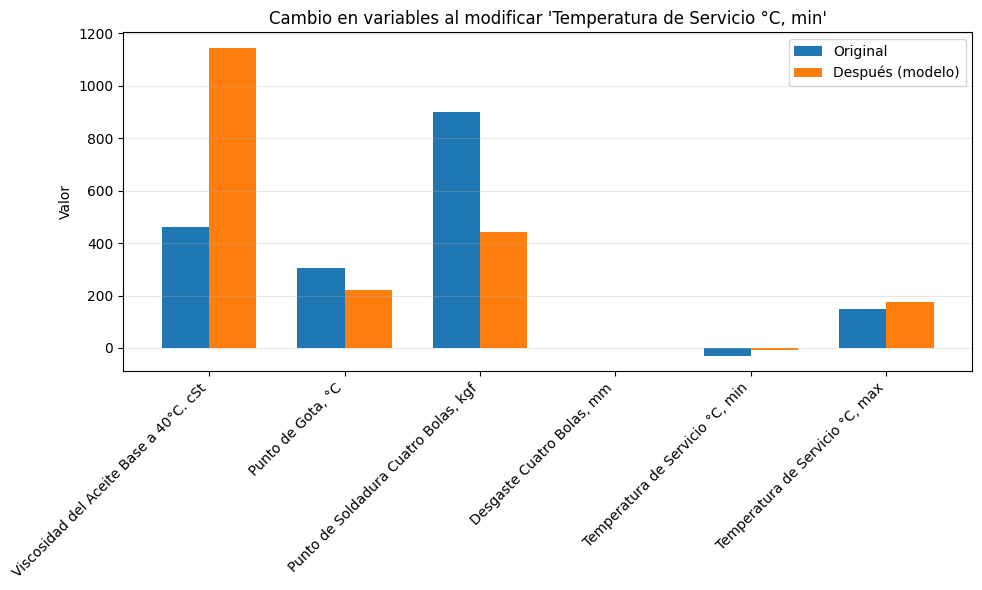

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


def variables_regresion(df, variable_objetivo, variables_predictoras):
    """
    Prepara X e y para una regresión lineal simple:
    - Filtra filas donde alguna variable (objetivo o predictoras) tenga -99.
    - Devuelve X, y y la lista de variables_predictoras.
    """
    df_filtrado = df.copy()
    for var in variables_predictoras + [variable_objetivo]:
        df_filtrado = df_filtrado[df_filtrado[var] != -99]
    
    X = df_filtrado[variables_predictoras]
    y = df_filtrado[variable_objetivo]
    
    return X, y, variables_predictoras


def entrenar_modelos_multivariables(expanded_data, variables_criticas, test_size=0.1, random_state=42):
    """
    Entrena un modelo de regresión lineal por cada variable crítica.
    Para cada variable_objetivo usa como predictoras las otras variables de variables_criticas.
    
    Regresa un diccionario:
    modelos[variable_objetivo] = {
        "modelo": LinearRegression entrenado,
        "scaler": StandardScaler ajustado a X,
        "predictoras": lista de nombres de columnas,
        "metricas": dict con mse_train, mse_test, r2_train, r2_test
    }
    """
    modelos = {}
    
    for variable_objetivo in variables_criticas:
        # todas menos la objetivo
        variables_predictoras = [v for v in variables_criticas if v != variable_objetivo]
        
        # preparar X e y
        X, y, features = variables_regresion(expanded_data, variable_objetivo, variables_predictoras)
        
        # split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # escalar
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # modelo
        modelo = LinearRegression()
        modelo.fit(X_train_scaled, y_train)
        
        # métricas
        y_pred_train = modelo.predict(X_train_scaled)
        y_pred_test = modelo.predict(X_test_scaled)
        
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        
        modelos[variable_objetivo] = {
            "modelo": modelo,
            "scaler": scaler,
            "predictoras": features,
            "metricas": {
                "mse_train": mse_train,
                "mse_test": mse_test,
                "r2_train": r2_train,
                "r2_test": r2_test,
            },
        }
    
    return modelos


def simular_cambio_grasa(grasa_real, modelos, variable_cambiada, delta):
    """
    Simula el cambio de una grasa real:
    - grasa_real: fila de df (pd.Series) con las variables críticas.
    - variable_cambiada: nombre de la columna que el usuario quiere mover.
    - delta: cuánto se suma/resta (ej. +5 grados).
    
    Usa los modelos globales para predecir TODOS los valores nuevos,
    tomando como entrada las variables de la grasa_real pero con variable_cambiada modificada.
    
    Regresa un DataFrame 'resumen' con:
        index = variables_criticas
        columnas = ["valor_original", "valor_modificado_input", "valor_predicho_modelo"]
    """
    if not isinstance(grasa_real, pd.Series):
        # si viene como fila de DF, lo convertimos
        grasa_real = grasa_real.squeeze()
    
    variables_criticas = list(modelos.keys())
    
    # valores originales
    resumen = pd.DataFrame(
        index=variables_criticas,
        columns=["valor_original", "valor_modificado_input", "valor_predicho_modelo"],
        dtype=float
    )
    
    for var in variables_criticas:
        resumen.loc[var, "valor_original"] = grasa_real[var]
    
    # aplicar cambio manual (delta) solo a esa grasa
    modificada = grasa_real.copy()
    modificada[variable_cambiada] = modificada[variable_cambiada] + delta
    
    for var in variables_criticas:
        resumen.loc[var, "valor_modificado_input"] = modificada[var]
    
    # usar cada modelo para predecir su variable objetivo
    for variable_objetivo, info in modelos.items():
        modelo = info["modelo"]
        scaler = info["scaler"]
        predictoras = info["predictoras"]
        
        X_input = modificada[predictoras].values.reshape(1, -1)
        X_input_scaled = scaler.transform(X_input)
        
        y_pred = modelo.predict(X_input_scaled)[0]
        resumen.loc[variable_objetivo, "valor_predicho_modelo"] = y_pred
    
    return resumen


def plot_cambio_variables(resumen, variable_cambiada):
    """
    Grafica barras comparando:
    - valor_original
    - valor_predicho_modelo (después del cambio)
    
    Se puede usar directamente después de simular_cambio_grasa.
    """
    vars_idx = resumen.index.tolist()
    x = np.arange(len(vars_idx))
    width = 0.35
    
    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, resumen["valor_original"], width, label="Original")
    plt.bar(x + width/2, resumen["valor_predicho_modelo"], width, label="Después (modelo)")
    
    plt.xticks(x, vars_idx, rotation=45, ha="right")
    plt.ylabel("Valor")
    plt.title(f"Cambio en variables al modificar '{variable_cambiada}'")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================================
# EJEMPLO DE USO (AJUSTA A TU CASO)
# ============================================================

# 1. definir variables críticas (las que quieres usar en la regresión)
variables_criticas = [
    "Viscosidad del Aceite Base a 40°C. cSt",
    "Punto de Gota, °C",
    "Punto de Soldadura Cuatro Bolas, kgf",
    "Desgaste Cuatro Bolas, mm",
    "Temperatura de Servicio °C, min",
    "Temperatura de Servicio °C, max",
]

# 2. generar datos simulados con VAE a partir del df real
#    (asumo que ya tienes df y la función simular_datos_vae definida)
expanded_data = simular_datos_vae(df, n_nuevos=1000)

# nos quedamos solo con las columnas numéricas críticas
expanded_data = expanded_data[variables_criticas]

# 3. entrenar un modelo lineal por variable crítica
modelos = entrenar_modelos_multivariables(
    expanded_data,
    variables_criticas=variables_criticas,
    test_size=0.1,
    random_state=42
)

# 4. elegir una grasa REAL de tu inventario (por ejemplo Grasa_2)
#    aquí depende cómo identificas la grasa: idDatosGrasa, codigoGrasa, etc.
grasa_2 = df[df["codigoGrasa"] == "Grasa_2"].iloc[0]
grasa_2_vars = grasa_2[variables_criticas]  # solo columnas numéricas

# 5. el usuario decide mover Temperatura de Servicio °C, min en +5 grados
variable_cambiada = "Temperatura de Servicio °C, min"
delta = 5.0

resumen_grasa2 = simular_cambio_grasa(
    grasa_real=grasa_2_vars,
    modelos=modelos,
    variable_cambiada=variable_cambiada,
    delta=delta
)

print("RESUMEN GRASA_2 (antes vs después vs modelo):")
print(resumen_grasa2)

# 6. graficar cómo se mueven las variables
plot_cambio_variables(resumen_grasa2, variable_cambiada)


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


# ============================================================
# 0. CARGAR TU DATA REAL
# ============================================================

datos_grasas_Tec = pd.read_csv("data/datos_grasas_Tec.csv", encoding="latin1")


# ============================================================
# 1. FUNCIONES BASE
# ============================================================

def variables_regresion(df, variable_objetivo, variables_predictoras):
    """
    Prepara X e y para una regresión lineal.
    Filtra filas donde alguna variable tenga -99.
    """
    df_filtrado = df.copy()

    for var in variables_predictoras + [variable_objetivo]:
        df_filtrado = df_filtrado[df_filtrado[var] != -99]

    X = df_filtrado[variables_predictoras]
    y = df_filtrado[variable_objetivo]

    return X, y, variables_predictoras


def entrenar_modelos_multivariables(df_expanded, variables_criticas):
    """
    Entrena un regresor de LinearRegression por cada variable crítica.
    """
    modelos = {}

    for variable_objetivo in variables_criticas:
        variables_predictoras = [v for v in variables_criticas if v != variable_objetivo]

        X, y, features = variables_regresion(df_expanded, variable_objetivo, variables_predictoras)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=42
        )

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        modelo = LinearRegression()
        modelo.fit(X_train_scaled, y_train)

        modelos[variable_objetivo] = {
            "modelo": modelo,
            "scaler": scaler,
            "predictoras": features,
            "metricas": {
                "mse_train": mean_squared_error(y_train, modelo.predict(X_train_scaled)),
                "mse_test": mean_squared_error(y_test, modelo.predict(X_test_scaled)),
                "r2_train": r2_score(y_train, modelo.predict(X_train_scaled)),
                "r2_test": r2_score(y_test, modelo.predict(X_test_scaled)),
            },
        }

    return modelos


def simular_cambio_grasa(
    grasa_real,
    modelos,
    variable_cambiada,
    delta,
    factor_ajuste=0.5,
):
    """
    Simula el efecto de modificar una variable de una grasa real.
    """
    if not isinstance(grasa_real, pd.Series):
        grasa_real = grasa_real.squeeze()

    variables_criticas = list(modelos.keys())

    resumen = pd.DataFrame(
        index=variables_criticas,
        columns=["valor_original", "valor_modificado_input", "valor_predicho_modelo"],
        dtype=float
    )

    # Valores originales
    for v in variables_criticas:
        resumen.loc[v, "valor_original"] = grasa_real[v]

    # Aplicar delta
    modificada = grasa_real.copy()
    modificada[variable_cambiada] = modificada[variable_cambiada] + delta

    for v in variables_criticas:
        resumen.loc[v, "valor_modificado_input"] = modificada[v]

    # Aplicar modelos
    for v_obj, info in modelos.items():
        modelo = info["modelo"]
        scaler = info["scaler"]
        predictoras = info["predictoras"]

        X_input = modificada[predictoras].values.reshape(1, -1)
        y_pred = modelo.predict(scaler.transform(X_input))[0]

        # suavizado
        y_original = grasa_real[v_obj]
        y_nuevo = y_original + factor_ajuste * (y_pred - y_original)

        resumen.loc[v_obj, "valor_predicho_modelo"] = y_nuevo

    return resumen


def plot_cambio_variables(resumen, variable_cambiada):
    """
    Gráfica original vs después (modelo)
    """
    vars_idx = resumen.index.tolist()
    x = np.arange(len(vars_idx))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, resumen["valor_original"], width, label="Original")
    plt.bar(x + width/2, resumen["valor_predicho_modelo"], width, label="Después (modelo)")

    plt.xticks(x, vars_idx, rotation=45, ha="right")
    plt.ylabel("Valor")
    plt.title(f"Cambio en variables al modificar '{variable_cambiada}'")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================================
# 2. PIPELINE COMPLETO (YA USANDO TU DATA REAL)
# ============================================================

# 2.1 Variables críticas (nombres EXACTOS del CSV)
variables_criticas = [
    "Viscosidad del Aceite Base a 40°C. cSt",
    "Punto de Gota, °C",
    "Punto de Soldadura Cuatro Bolas, kgf",
    "Desgaste Cuatro Bolas, mm",
    "Temperatura de Servicio °C, min",
    "Temperatura de Servicio °C, max",
]

# 2.2 Preparar input del VAE SOLO con esas columnas
df_vae_input = datos_grasas_Tec[variables_criticas].copy()

# 2.3 Generar datos sintéticos VAE
expanded_data = simular_datos_vae(df_vae_input, n_nuevos=1000)

# Si el VAE regresa array → poner nombres correctos:
if not isinstance(expanded_data, pd.DataFrame):
    expanded_data = pd.DataFrame(expanded_data, columns=variables_criticas)

# 2.4 Entrenar regresores
modelos = entrenar_modelos_multivariables(expanded_data, variables_criticas)

# 2.5 Tomar una grasa REAL del inventario
grasa_real = datos_grasas_Tec[datos_grasas_Tec["codigoGrasa"] == "Grasa_2"].iloc[0]
grasa_real_vars = grasa_real[variables_criticas]

# 2.6 Simular cambio
variable_cambiada = "Temperatura de Servicio °C, min"
delta = 5  # ejemplo: subir Tmin +5°C

resumen = simular_cambio_grasa(
    grasa_real=grasa_real_vars,
    modelos=modelos,
    variable_cambiada=variable_cambiada,
    delta=delta,
    factor_ajuste=0.5
)

print(resumen)

# 2.7 Gráfica final
plot_cambio_variables(resumen, variable_cambiada)


KeyError: 'Punto de Gota, °C'

In [72]:
print(datos_grasas_Tec.columns.tolist())


['idDatosGrasas', 'codigoGrasa', 'Aceite Base', 'Espesante', 'Grado NLGI Consistencia', 'Viscosidad del Aceite Base a 40°C. cSt', 'Penetración de Cono a 25°C, 0.1mm', 'Punto de Gota, °C', 'Estabilidad Mecánica, %', 'Punto de Soldadura Cuatro Bolas, kgf', 'Desgaste Cuatro Bolas, mm', 'Indice de Carga-Desgaste', 'Carga Timken Ok, lb', 'Resistencia al Lavado por Agua a 80°C, %', 'Corrion EMCOR', 'Corrosión al Cobre', 'Prueba FZG', 'Registro NSF', 'Solidos Totales, %', 'Tamaño de Particula, µ', 'Bombeabilidad', 'Clasificacion ISO 6743-9', 'Presion de Flujo a -30°C, mbar', 'Separacion del Aceite, %', 'Prevencion a la Corrosion', 'Estabilidad a la Oxidacion', 'Resistencia a la Humedad', 'pH', 'Factor de Torque', 'Viscosidad Dinámica a 25°C, cP', 'Biodegradabilidad en 28 dias (> 60%)', 'Factor de Velocidad', 'Temperatura de Servicio °C, min', 'Temperatura de Servicio °C, max', 'categoria', 'subtitulo', 'descripcion', 'beneficios', 'aplicaciones', 'color', 'textura']


In [73]:
for col in datos_grasas_Tec.columns:
    print(repr(col))


'idDatosGrasas'
'codigoGrasa'
'Aceite Base'
'Espesante'
'Grado NLGI Consistencia'
'Viscosidad del Aceite Base a 40°C. cSt'
'Penetración de Cono a 25°C, 0.1mm'
'Punto de Gota, °C'
'Estabilidad Mecánica, %'
'Punto de Soldadura Cuatro Bolas, kgf'
'Desgaste Cuatro Bolas, mm'
'Indice de Carga-Desgaste'
'Carga Timken Ok, lb'
'Resistencia al Lavado por Agua a 80°C, %'
'Corrion EMCOR'
'Corrosión al Cobre'
'Prueba FZG'
'Registro NSF'
'Solidos Totales, %'
'Tamaño de Particula, µ'
'Bombeabilidad'
'Clasificacion ISO 6743-9'
'Presion de Flujo a -30°C, mbar'
'Separacion del Aceite, %'
'Prevencion a la Corrosion'
'Estabilidad a la Oxidacion'
'Resistencia a la Humedad'
'pH'
'Factor de Torque'
'Viscosidad Dinámica a 25°C, cP'
'Biodegradabilidad en 28 dias (> 60%)'
'Factor de Velocidad'
'Temperatura de Servicio °C, min'
'Temperatura de Servicio °C, max'
'categoria'
'subtitulo'
'descripcion'
'beneficios'
'aplicaciones'
'color'
'textura'


In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


# ============================================================
# 0. CARGAR TU DATA REAL
# ============================================================

datos_grasas_Tec = pd.read_csv("data/datos_grasas_Tec.csv", encoding="latin1")


# ============================================================
# 1. VARIABLES CRÍTICAS (NOMBRES EXACTOS)
# ============================================================

variables_criticas = [
    "Viscosidad del Aceite Base a 40°C. cSt",
    "Punto de Gota, °C",
    "Punto de Soldadura Cuatro Bolas, kgf",
    "Desgaste Cuatro Bolas, mm",
    "Temperatura de Servicio °C, min",
    "Temperatura de Servicio °C, max",
]


# ============================================================
# 2. FUNCIONES DEL REGRESOR
# ============================================================

def variables_regresion(df, variable_objetivo, variables_predictoras):
    df_filtrado = df.copy()
    for var in variables_predictoras + [variable_objetivo]:
        df_filtrado = df_filtrado[df_filtrado[var] != -99]
    X = df_filtrado[variables_predictoras]
    y = df_filtrado[variable_objetivo]
    return X, y, variables_predictoras


def entrenar_modelos_multivariables(df_expanded, variables_criticas):
    modelos = {}
    for variable_objetivo in variables_criticas:
        variables_predictoras = [v for v in variables_criticas if v != variable_objetivo]

        X, y, features = variables_regresion(df_expanded, variable_objetivo, variables_predictoras)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=42
        )

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        modelo = LinearRegression()
        modelo.fit(X_train_scaled, y_train)

        modelos[variable_objetivo] = {
            "modelo": modelo,
            "scaler": scaler,
            "predictoras": features,
            "metricas": {
                "mse_train": mean_squared_error(y_train, modelo.predict(X_train_scaled)),
                "mse_test": mean_squared_error(y_test, modelo.predict(X_test_scaled)),
                "r2_train": r2_score(y_train, modelo.predict(X_train_scaled)),
                "r2_test": r2_score(y_test, modelo.predict(X_test_scaled)),
            },
        }
    return modelos


def simular_cambio_grasa(grasa_real, modelos, variable_cambiada, delta, factor_ajuste=0.5):
    if not isinstance(grasa_real, pd.Series):
        grasa_real = grasa_real.squeeze()

    variables_criticas = list(modelos.keys())

    resumen = pd.DataFrame(
        index=variables_criticas,
        columns=["valor_original", "valor_modificado_input", "valor_predicho_modelo"],
        dtype=float
    )

    # original
    for v in variables_criticas:
        resumen.loc[v, "valor_original"] = grasa_real[v]

    # cambio manual
    modificada = grasa_real.copy()
    modificada[variable_cambiada] = modificada[variable_cambiada] + delta

    for v in variables_criticas:
        resumen.loc[v, "valor_modificado_input"] = modificada[v]

    # predicción
    for v_obj, info in modelos.items():
        modelo = info["modelo"]
        scaler = info["scaler"]
        preds = info["predictoras"]

        X_input = modificada[preds].values.reshape(1, -1)
        y_pred = modelo.predict(scaler.transform(X_input))[0]

        y_original = grasa_real[v_obj]
        y_nuevo = y_original + factor_ajuste * (y_pred - y_original)

        resumen.loc[v_obj, "valor_predicho_modelo"] = y_nuevo

    return resumen


def plot_cambio_variables(resumen, variable_cambiada):
    x = np.arange(len(resumen.index))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, resumen["valor_original"], width, label="Original")
    plt.bar(x + width/2, resumen["valor_predicho_modelo"], width, label="Después (modelo)")

    plt.xticks(x, resumen.index, rotation=45, ha="right")
    plt.ylabel("Valor")
    plt.title(f"Cambio al modificar: {variable_cambiada}")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================================
# 3. PIPELINE — GENERAR EXPANDED DATA (VAE)
# ============================================================

df_vae_input = datos_grasas_Tec[variables_criticas].copy()

expanded_data = simular_datos_vae(df_vae_input, n_nuevos=1000)

if not isinstance(expanded_data, pd.DataFrame):
    expanded_data = pd.DataFrame(expanded_data, columns=variables_criticas)


# ============================================================
# 4. ENTRENAR REGRESORES
# ============================================================

modelos = entrenar_modelos_multivariables(expanded_data, variables_criticas)


# ============================================================
# 5. SIMULAR CAMBIO EN UNA GRASA REAL
# ============================================================

grasa_real = datos_grasas_Tec[datos_grasas_Tec["codigoGrasa"] == "Grasa_2"].iloc[0]
grasa_real_vars = grasa_real[variables_criticas]

resumen = simular_cambio_grasa(
    grasa_real=grasa_real_vars,
    modelos=modelos,
    variable_cambiada="Temperatura de Servicio °C, min",
    delta=5,
    factor_ajuste=0.5
)

print(resumen)

plot_cambio_variables(resumen, "Temperatura de Servicio °C, min")


KeyError: 'Punto de Gota, °C'

Columnas que regresó el VAE:
['Viscosidad del Aceite Base a 40°C. cSt', 'Punto de Soldadura Cuatro Bolas, kgf', 'Desgaste Cuatro Bolas, mm', 'Temperatura de Servicio °C, min', 'Temperatura de Servicio °C, max']
⚠️ Estas columnas de variables_criticas NO están en expanded_data:
{'Punto de Gota, °C'}

Métricas para Viscosidad del Aceite Base a 40°C. cSt:
{'mse_train': 10256.546895317728, 'mse_test': 10014.371770016494, 'r2_train': 0.5542431306503552, 'r2_test': 0.5237349359100298}

Métricas para Punto de Soldadura Cuatro Bolas, kgf:
{'mse_train': 538.8406003046413, 'mse_test': 634.1237557648919, 'r2_train': 0.2406544718638779, 'r2_test': 0.13220539859869163}

Métricas para Desgaste Cuatro Bolas, mm:
{'mse_train': 2.714989761861393e-05, 'mse_test': 2.4666854923919107e-05, 'r2_train': 0.41144204086305225, 'r2_test': 0.46797809441261473}

Métricas para Temperatura de Servicio °C, min:
{'mse_train': 0.7031603393355317, 'mse_test': 0.734882244740333, 'r2_train': 0.5519577860200626, 'r2_test':

c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with featur

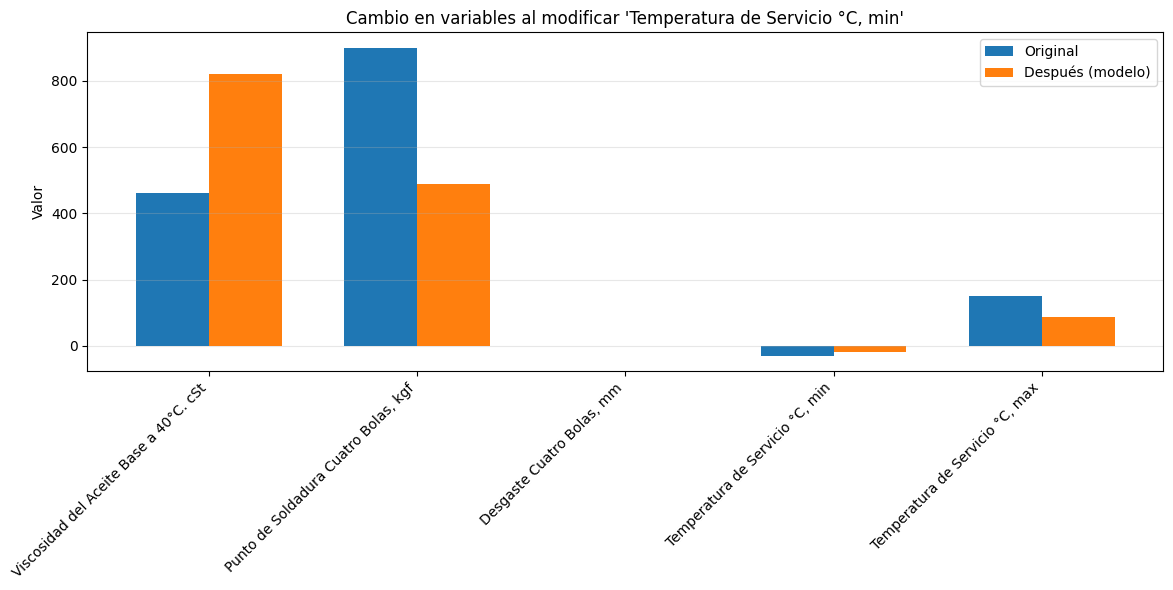

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


# ============================================================
# 0. CARGAR DATA REAL
# ============================================================

datos_grasas_Tec = pd.read_csv("data/datos_grasas_Tec.csv", encoding="latin1")


# ============================================================
# 1. VARIABLES CRÍTICAS (NOMBRES EXACTOS DEL CSV)
# ============================================================

variables_criticas = [
    "Viscosidad del Aceite Base a 40°C. cSt",
    "Punto de Gota, °C",
    "Punto de Soldadura Cuatro Bolas, kgf",
    "Desgaste Cuatro Bolas, mm",
    "Temperatura de Servicio °C, min",
    "Temperatura de Servicio °C, max",
]


# ============================================================
# 2. FUNCIONES DE REGRESIÓN
# ============================================================

def variables_regresion(df, variable_objetivo, variables_predictoras):
    """
    Prepara X e y para una regresión lineal.
    Filtra filas donde alguna variable (predictora u objetivo) tenga el valor -99.
    """
    df_filtrado = df.copy()
    for var in variables_predictoras + [variable_objetivo]:
        df_filtrado = df_filtrado[df_filtrado[var] != -99]
    X = df_filtrado[variables_predictoras]
    y = df_filtrado[variable_objetivo]
    return X, y, variables_predictoras


def entrenar_modelos_multivariables(df_expanded, variables_criticas):
    """
    Entrena un modelo LinearRegression por cada variable crítica usando
    las demás variables críticas como predictoras.
    """
    modelos = {}
    for variable_objetivo in variables_criticas:
        variables_predictoras = [v for v in variables_criticas if v != variable_objetivo]

        X, y, features = variables_regresion(df_expanded, variable_objetivo, variables_predictoras)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=42
        )

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        modelo = LinearRegression()
        modelo.fit(X_train_scaled, y_train)

        modelos[variable_objetivo] = {
            "modelo": modelo,
            "scaler": scaler,
            "predictoras": features,
            "metricas": {
                "mse_train": mean_squared_error(y_train, modelo.predict(X_train_scaled)),
                "mse_test": mean_squared_error(y_test, modelo.predict(X_test_scaled)),
                "r2_train": r2_score(y_train, modelo.predict(X_train_scaled)),
                "r2_test": r2_score(y_test, modelo.predict(X_test_scaled)),
            },
        }
    return modelos


def simular_cambio_grasa(
    grasa_real,
    modelos,
    variable_cambiada,
    delta,
    factor_ajuste=0.5,
):
    """
    Simula el efecto de modificar una variable de una grasa real.

    - grasa_real: pd.Series con las variables_criticas de una fila real.
    - variable_cambiada: nombre de la variable que el usuario mueve.
    - delta: cuánto se suma/resta (ej. +5 °C).
    - factor_ajuste: 0–1, cuánto confiar en el valor del modelo (1 = 100%).

    Devuelve un DataFrame con:
    - valor_original
    - valor_modificado_input
    - valor_predicho_modelo
    """
    if not isinstance(grasa_real, pd.Series):
        grasa_real = grasa_real.squeeze()

    variables = list(modelos.keys())

    resumen = pd.DataFrame(
        index=variables,
        columns=["valor_original", "valor_modificado_input", "valor_predicho_modelo"],
        dtype=float
    )

    # Valores originales
    for v in variables:
        resumen.loc[v, "valor_original"] = grasa_real[v]

    # Aplicar delta manual
    modificada = grasa_real.copy()
    modificada[variable_cambiada] = modificada[variable_cambiada] + delta

    for v in variables:
        resumen.loc[v, "valor_modificado_input"] = modificada[v]

    # Predicción con cada modelo
    for v_obj, info in modelos.items():
        modelo = info["modelo"]
        scaler = info["scaler"]
        preds = info["predictoras"]

        X_input = modificada[preds].values.reshape(1, -1)
        X_scaled = scaler.transform(X_input)
        y_pred = modelo.predict(X_scaled)[0]

        y_original = grasa_real[v_obj]
        y_nuevo = y_original + factor_ajuste * (y_pred - y_original)

        resumen.loc[v_obj, "valor_predicho_modelo"] = y_nuevo

    return resumen


def plot_cambio_variables(resumen, variable_cambiada):
    """
    Gráfica de barras: valor original vs valor predicho por el modelo
    después del cambio en `variable_cambiada`.
    """
    x = np.arange(len(resumen.index))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, resumen["valor_original"], width, label="Original")
    plt.bar(x + width/2, resumen["valor_predicho_modelo"], width, label="Después (modelo)")

    plt.xticks(x, resumen.index, rotation=45, ha="right")
    plt.ylabel("Valor")
    plt.title(f"Cambio en variables al modificar '{variable_cambiada}'")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================================
# 3. GENERAR EXPANDED_DATA CON VAE Y AJUSTAR COLUMNAS
# ============================================================

# Input al VAE: solo las columnas críticas de tu df real
df_vae_input = datos_grasas_Tec[variables_criticas].copy()

# Tu función VAE (ya la tienes implementada)
expanded_data = simular_datos_vae(df_vae_input, n_nuevos=1000)

# Si el VAE devuelve un array numpy, le ponemos nombres de columnas
if not isinstance(expanded_data, pd.DataFrame):
    expanded_data = pd.DataFrame(expanded_data, columns=variables_criticas)

print("Columnas que regresó el VAE:")
print(expanded_data.columns.tolist())

# Usar SOLO las columnas que existan en expanded_data (por si acaso)
cols_expanded = expanded_data.columns.tolist()
cols_comunes = [c for c in variables_criticas if c in cols_expanded]

if len(cols_comunes) < len(variables_criticas):
    print("⚠️ Estas columnas de variables_criticas NO están en expanded_data:")
    faltan = set(variables_criticas) - set(cols_comunes)
    print(faltan)

variables_criticas = cols_comunes
expanded_data = expanded_data[variables_criticas]


# ============================================================
# 4. ENTRENAR REGRESORES
# ============================================================

modelos = entrenar_modelos_multivariables(expanded_data, variables_criticas)

# Puedes ver métricas si quieres:
for var, info in modelos.items():
    print(f"\nMétricas para {var}:")
    print(info["metricas"])


# ============================================================
# 5. SIMULAR CAMBIO EN UNA GRASA REAL
# ============================================================

# Ejemplo: seleccionar la grasa con codigoGrasa == "Grasa_2"
grasa_real = datos_grasas_Tec[datos_grasas_Tec["codigoGrasa"] == "Grasa_2"].iloc[0]
grasa_real_vars = grasa_real[variables_criticas]

variable_cambiada = "Temperatura de Servicio °C, min"
delta = -20  # subir 5°C

resumen = simular_cambio_grasa(
    grasa_real=grasa_real_vars,
    modelos=modelos,
    variable_cambiada=variable_cambiada,
    delta=delta,
    factor_ajuste=0.5  # prueba con 0.3, 0.5, 1.0
)

print("\nResumen de la simulación para Grasa_2:")
print(resumen)

plot_cambio_variables(resumen, variable_cambiada)
